# Proposed Model VS Speckle2Void, SAR2SAR and CNN-NLM

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from DatasetHandler import DatasetHandler
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np

In [3]:
def plot_model_results(batch_speckle, batch_clean, batch_pred):
    n = batch_speckle.shape[0]

    for i in range(n):
        fig, axes = plt.subplots(
        nrows = 2,
        ncols = 4, 
        figsize = (16, 8))

        print('-------------------------------------------------------------------------------------------')
        print('Test', i)

        axes[0,0].imshow(batch_speckle[i,...,0], cmap='gray')
        axes[0,0].set_title('Input with speckle')
        axes[0,1].imshow(batch_clean[i,...,0], cmap='gray')
        axes[0,1].set_title('Ground truth')
        axes[0,2].imshow(batch_pred[i,...,0], cmap='gray')
        axes[0,2].set_title('Model Prediction')
        diff = np.abs(batch_pred[i,...,0] - batch_clean[i,...,0])
        axes[0,3].imshow(diff, vmin=np.min(diff), vmax=np.max(diff), cmap='gray')
        axes[0,3].set_title('|Model Prediction - Ground Truth|')
        
        try:
            axes[1,0].hist(batch_speckle[i,...,0].flatten(), bins=20, histtype='step')
            axes[1,0].set_title('Input with speckle')
            axes[1,1].hist(batch_clean[i,...,0].flatten(), bins=20, histtype='step')
            axes[1,1].set_title('Ground truth')
            axes[1,2].hist(batch_pred[i,...,0].flatten(), bins=20, histtype='step')
            axes[1,2].set_title('Model Prediction')
            axes[1,3].hist(diff.flatten(), bins=20, histtype='step')
            axes[1,3].set_title('|Model Prediction - Ground Truth|')
        except:
            pass
    
        plt.show()
        plt.close()

def compute_metrics(batch_speckle, batch_clean, batch_pred):
    n = batch_speckle.shape[0]
    
    print('===========================================================================================================================================')
    print('  Test \t\t Metric\t\tGrount Truth VS Grount Truth \t\t Grount Truth VS Input \t\t Grount Truth VS Model Prediction')
    print('-------------------------------------------------------------------------------------------------------------------------------------------')
    for i in range(n):
        gt_vs_gt = peak_signal_noise_ratio(batch_clean[i, ...,0], batch_clean[i, ...,0], data_range=1.0)
        gt_vs_in  = peak_signal_noise_ratio(batch_clean[i, ...,0], batch_speckle[i,...,0], data_range=1.0)
        gt_vs_pred  = peak_signal_noise_ratio(batch_clean[i, ...,0], batch_pred[i,...,0], data_range=1.0)

        print('   %i  \t\t  PSNR \t\t             %.2f             \t\t             %.2f      \t\t             %.2f' % (i, gt_vs_gt, gt_vs_in, gt_vs_pred))
        
        gt_vs_gt = structural_similarity(batch_clean[i, ...,0], batch_clean[i, ...,0], data_range=1.0)
        gt_vs_in  = structural_similarity(batch_clean[i, ...,0], batch_speckle[i,...,0], data_range=1.0)
        gt_vs_pred  = structural_similarity(batch_clean[i, ...,0], batch_pred[i,...,0], data_range=1.0)
        print('   %i  \t\t  SSIM \t\t             %.2f             \t\t             %.2f      \t\t             %.2f' % (i, gt_vs_gt, gt_vs_in, gt_vs_pred))
        
        enl_spe  = (np.mean(batch_speckle[i,...,0])**2)/(np.std(batch_speckle[i,...,0])**2)
        enl_clean = (np.mean(batch_clean[i, ...,0])**2)/(np.std(batch_clean[i, ...,0])**2)
        enl_filter = (np.mean(batch_pred[i,...,0])**2)/(np.std(batch_pred[i,...,0])**2)
        print('   %i  \t\t  ENL  \t\t             %.2f             \t\t             %.2f      \t\t             %.2f' % (i, enl_clean, enl_spe, enl_filter))
        print('-------------------------------------------------------------------------------------------------------------------------------------------')

In [4]:
import sys
sys.path.append('speckle2void')
sys.path.append('SAR2SAR-GRD-test')
sys.path.append('CNN-NLM')
sys.path.insert(0, './libraries')

In [5]:
handler = DatasetHandler('dataset_v2')
print("Training dataset size: ", len(handler.train_paths))
print("Validation dataset size: ", len(handler.val_paths))
print("Testing dataset size: ", len(handler.test_paths))

Training dataset size:  2000
Validation dataset size:  600
Testing dataset size:  37


In [6]:
compute_max_min = False

if compute_max_min:
    MAX, MIN = handler.getstats(handler.train_paths)
else:
    MAX = 29968.252
    MIN = 0

print('Dataset max: ', MAX, 'Dataset min: ', MIN)

Dataset max:  29968.252 Dataset min:  0


In [7]:
IMG_SHAPE = (96,96,1)

In [8]:
batch_speckle, batch_clean = handler.data_loader_v2(
    paths      = handler.test_paths, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN)

# Speckle 2 void

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from Speckle2Void import Speckle2V

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
tf.reset_default_graph()
batch_size=16

dir_train = None
dir_test = None

file_checkpoint = 'speckle2void/s2v_checkpoint/model.ckpt-299999'#None for the latest checkpoint

model = Speckle2V(dir_train,
                  dir_test,
                  file_checkpoint,
                  batch_size=batch_size,
                  patch_size=64,
                  model_name='speckle2void',
                  lr=1e-04, 
                  steps_per_epoch=2000,
                  k_penalty_tv=5e-05,
                  shift_list=[3,1],
                  prob = [0.9,0.1],
                  clip=1,
                  norm=1,
                  L_noise=1)   

In [12]:
model.build_inference()
model.load_weights()

Instructions for updating:
Colocations handled automatically by placer.


/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Taking the specified checkpoint...
INFO:tensorflow:Restoring parameters from speckle2void/s2v_checkpoint/model.ckpt-299999


In [15]:
batch_pred = model.predict(batch_speckle)

-------------------------------------------------------------------------------------------
Test 0


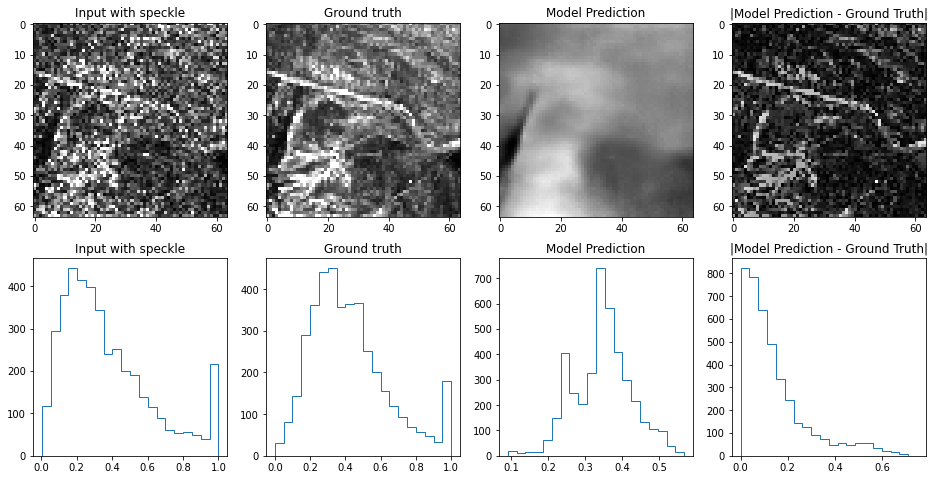

-------------------------------------------------------------------------------------------
Test 1


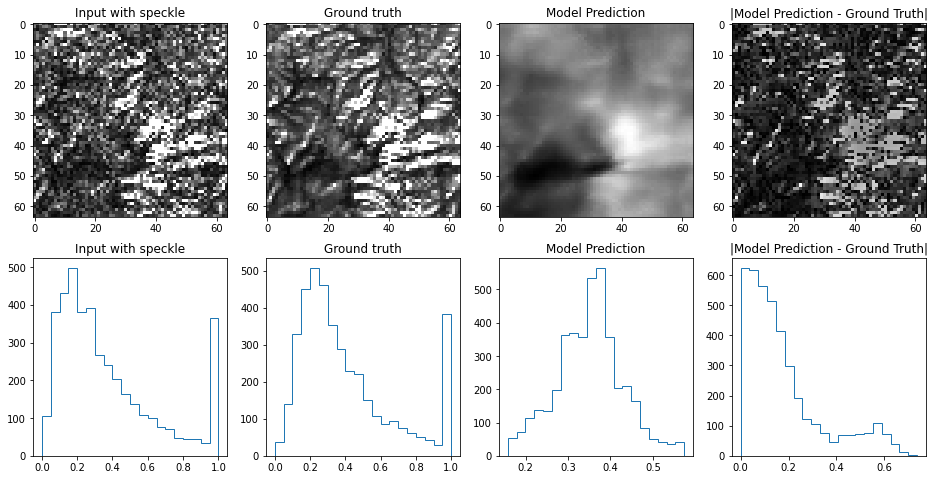

-------------------------------------------------------------------------------------------
Test 2


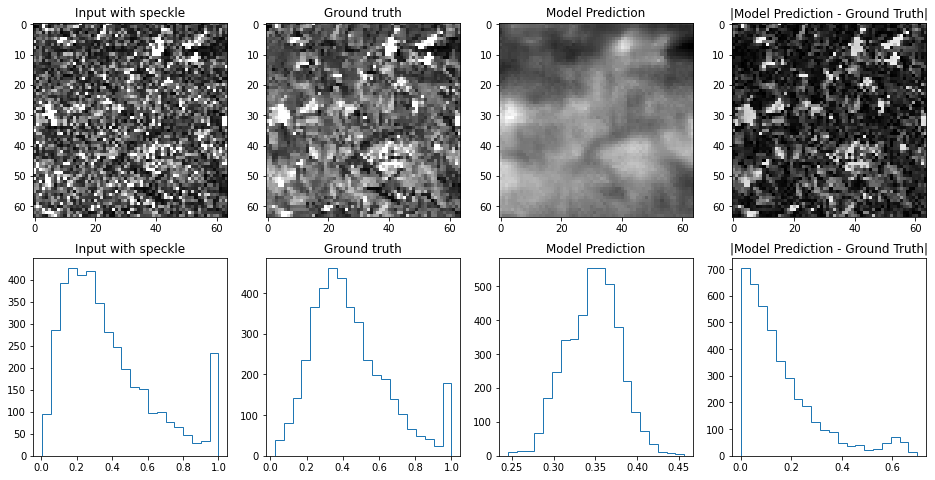

-------------------------------------------------------------------------------------------
Test 3


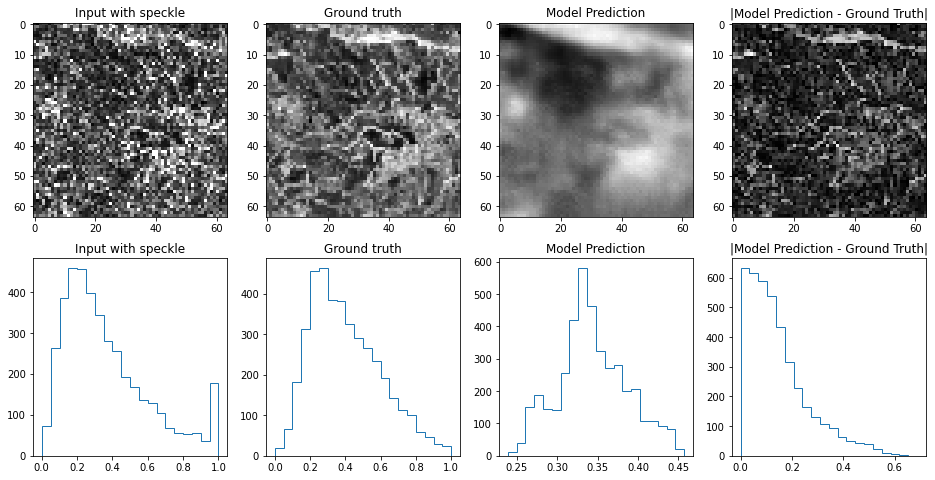

-------------------------------------------------------------------------------------------
Test 4


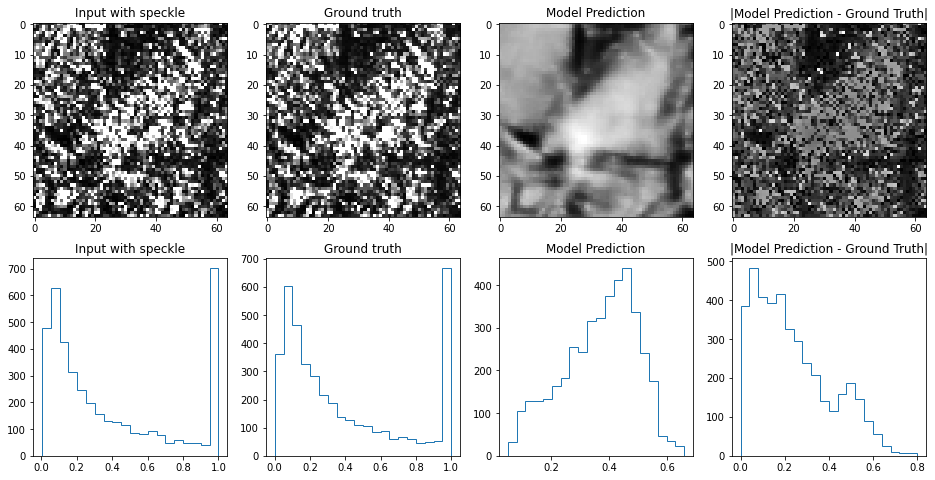

-------------------------------------------------------------------------------------------
Test 5


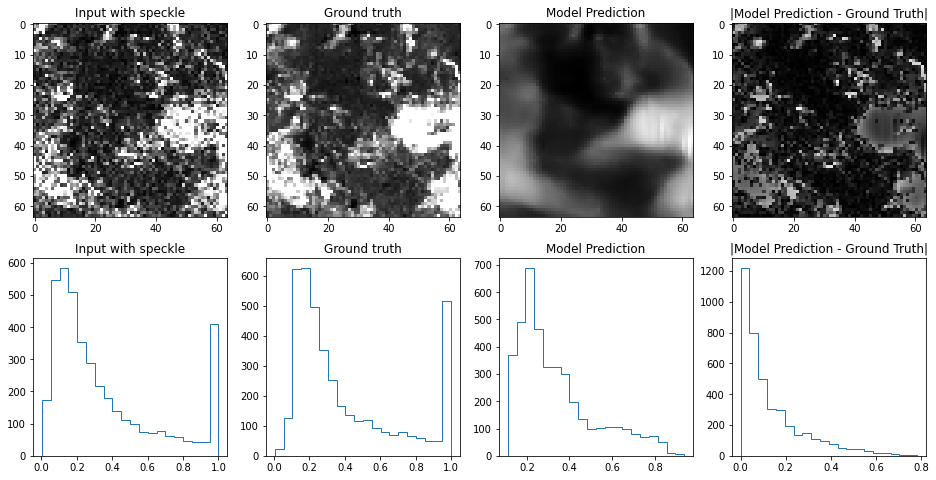

-------------------------------------------------------------------------------------------
Test 6


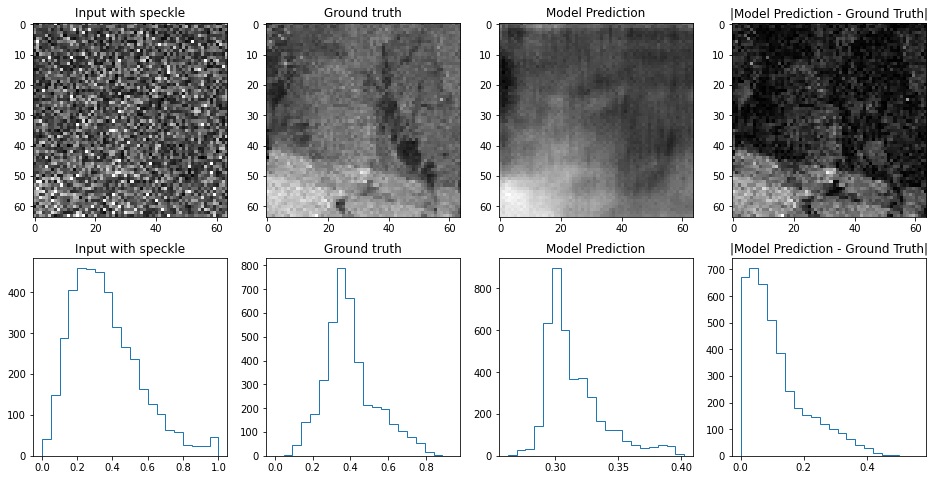

-------------------------------------------------------------------------------------------
Test 7


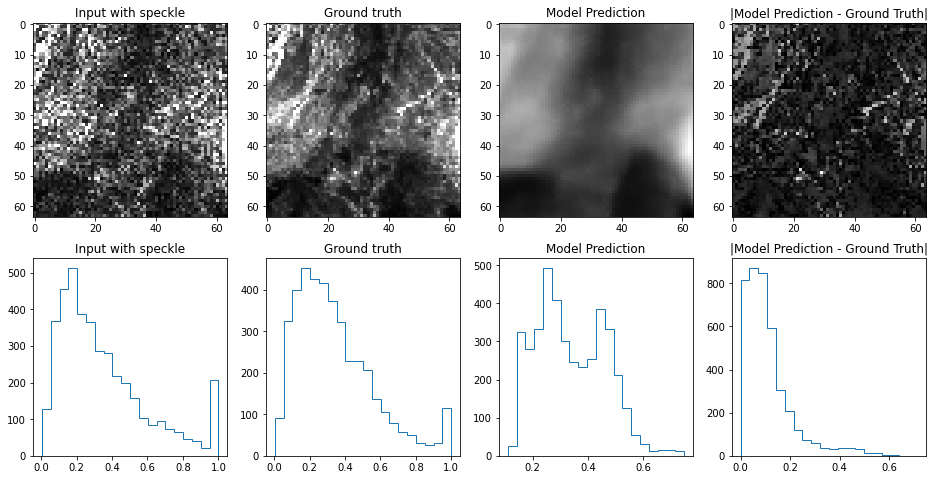

-------------------------------------------------------------------------------------------
Test 8


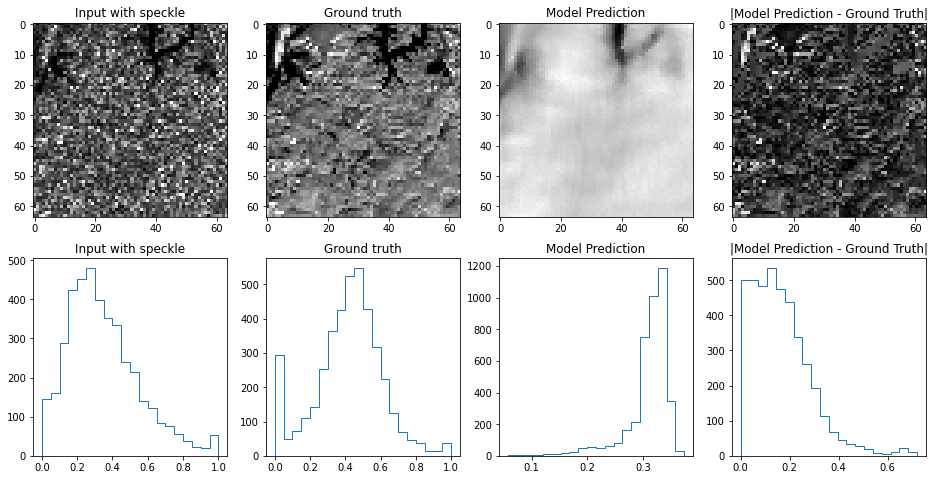

-------------------------------------------------------------------------------------------
Test 9


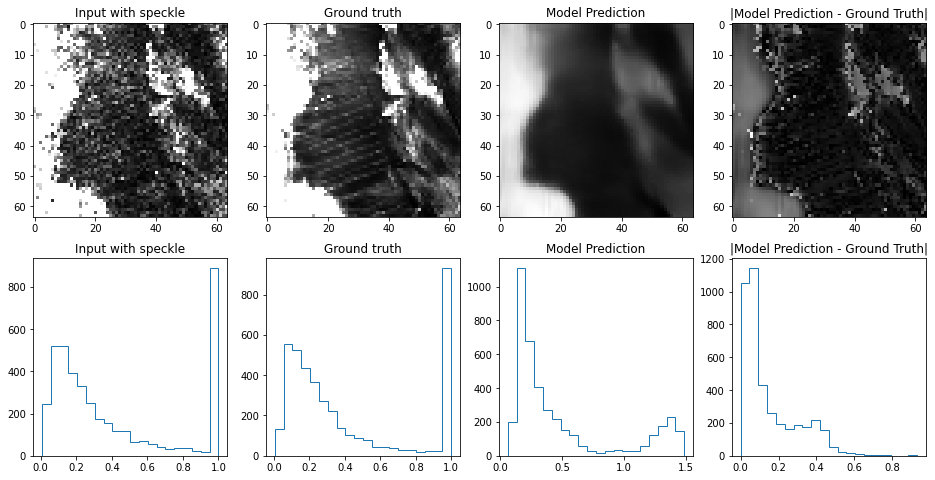

-------------------------------------------------------------------------------------------
Test 10


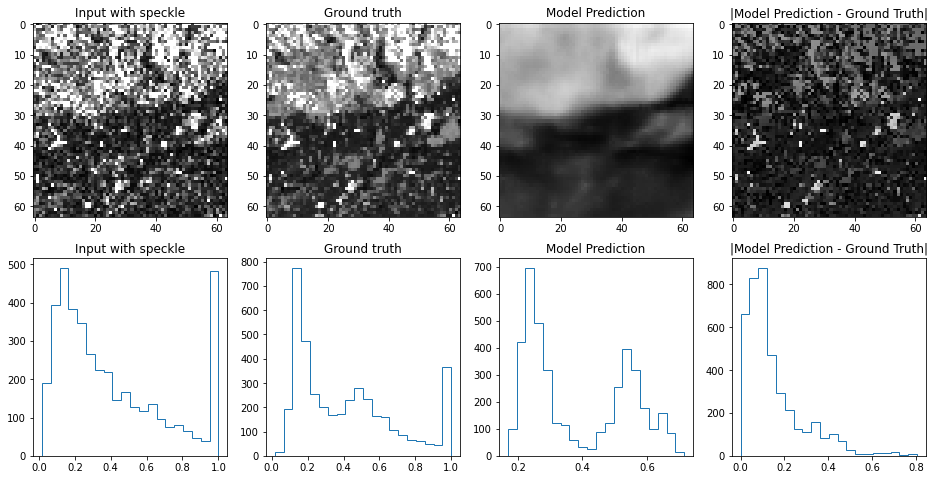

-------------------------------------------------------------------------------------------
Test 11


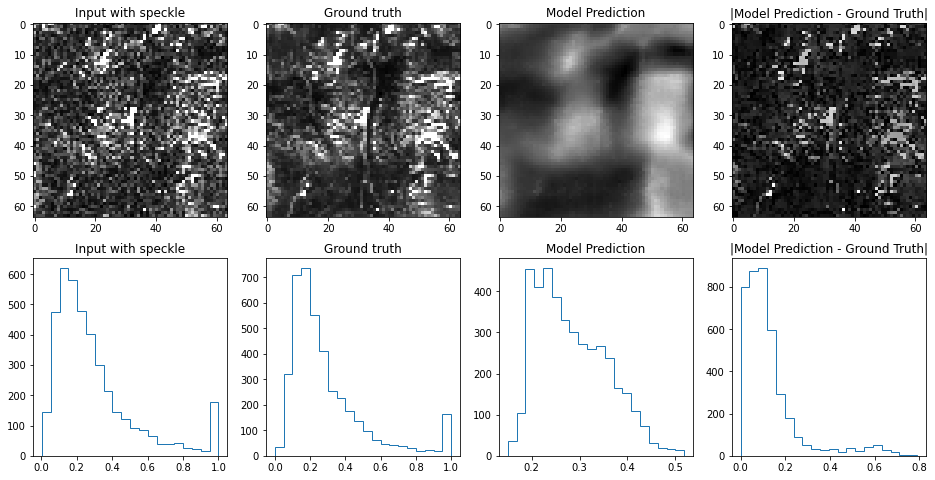

-------------------------------------------------------------------------------------------
Test 12


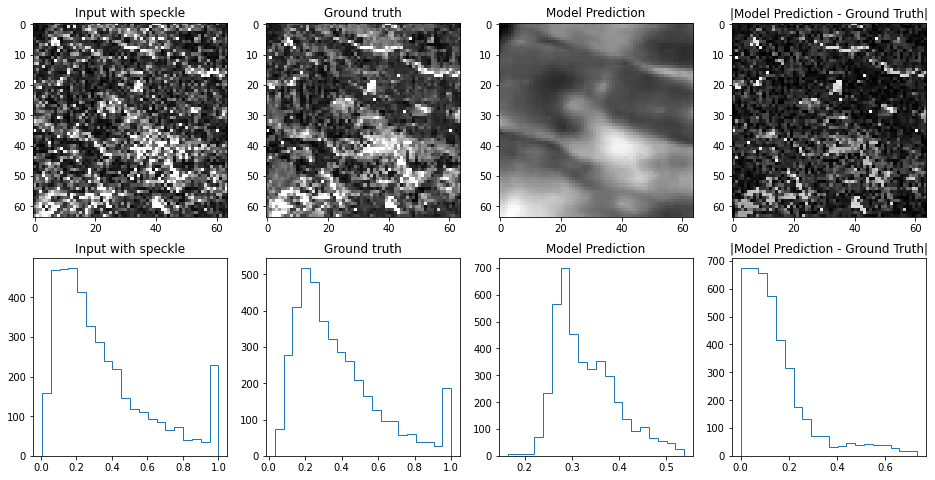

-------------------------------------------------------------------------------------------
Test 13


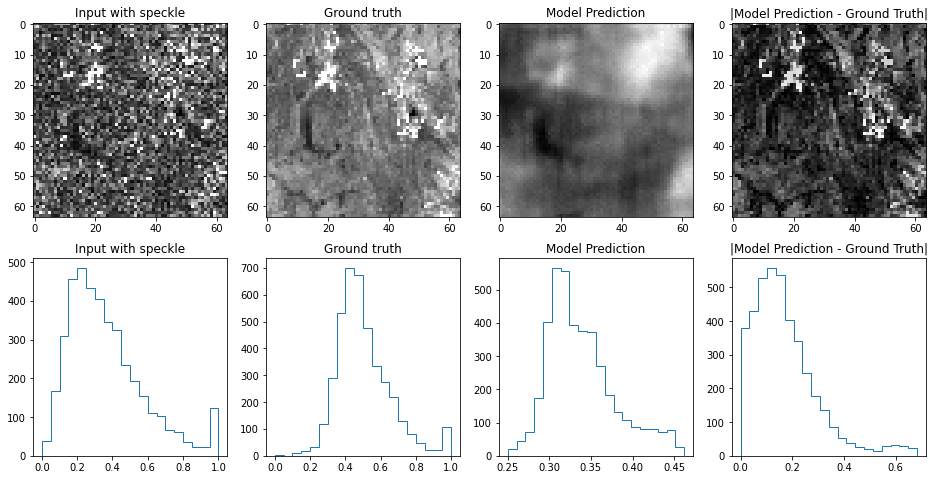

-------------------------------------------------------------------------------------------
Test 14


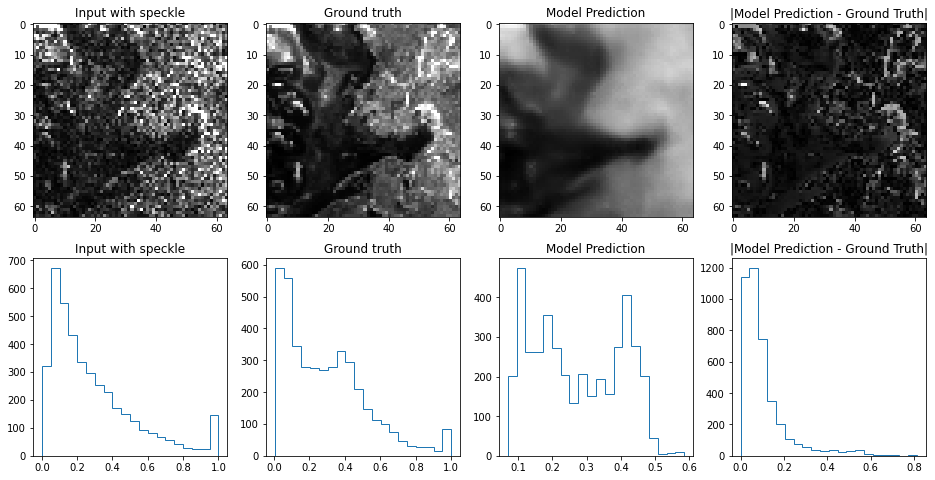

-------------------------------------------------------------------------------------------
Test 15


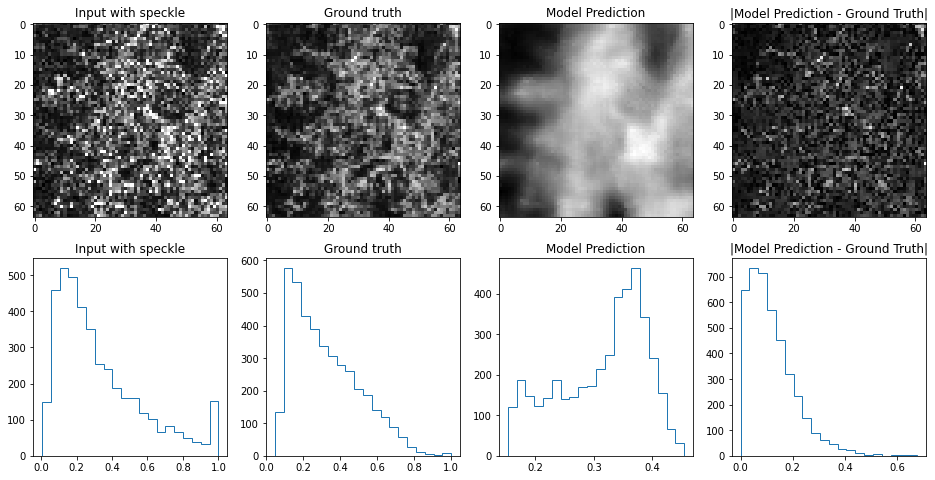

-------------------------------------------------------------------------------------------
Test 16


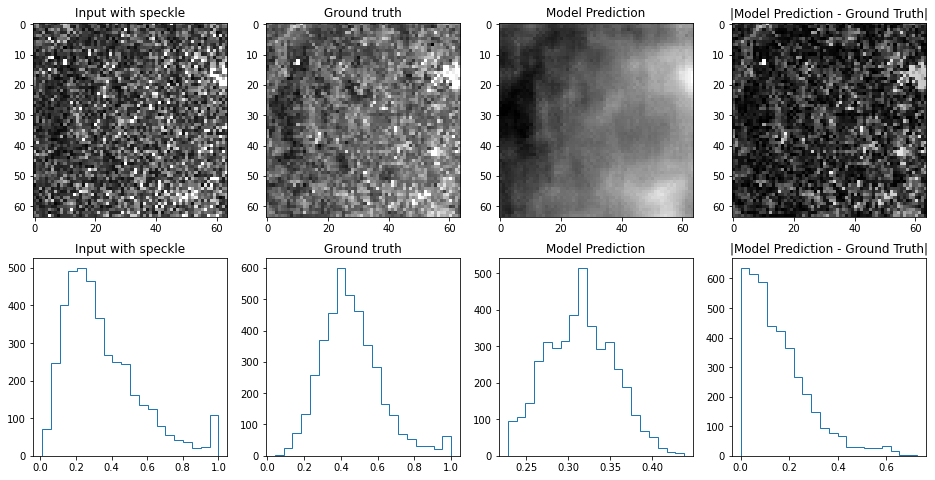

-------------------------------------------------------------------------------------------
Test 17


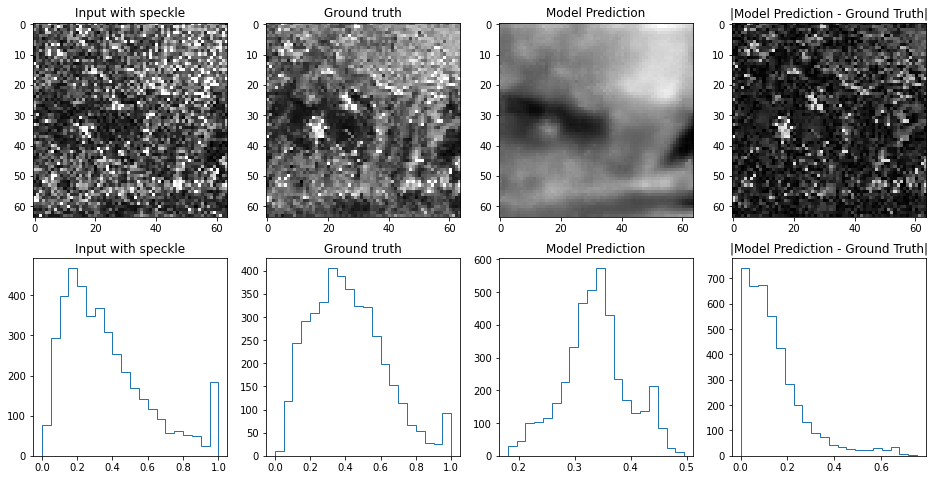

-------------------------------------------------------------------------------------------
Test 18


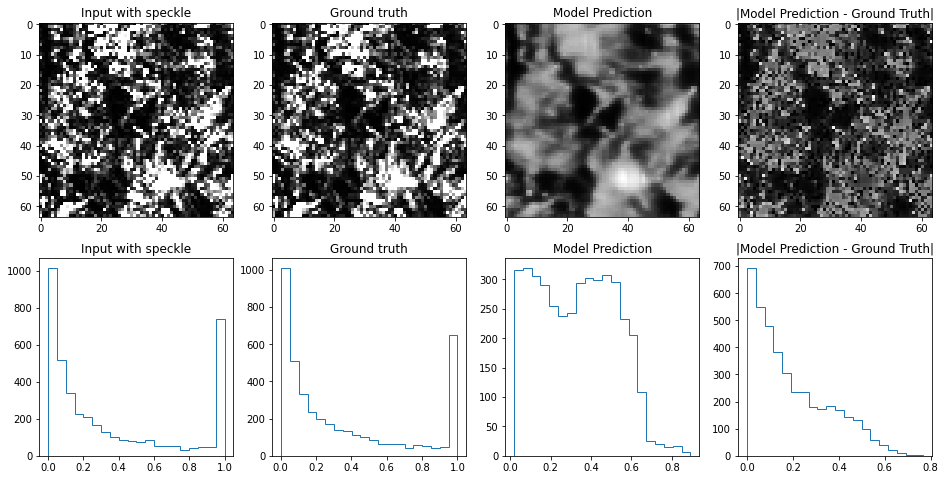

-------------------------------------------------------------------------------------------
Test 19


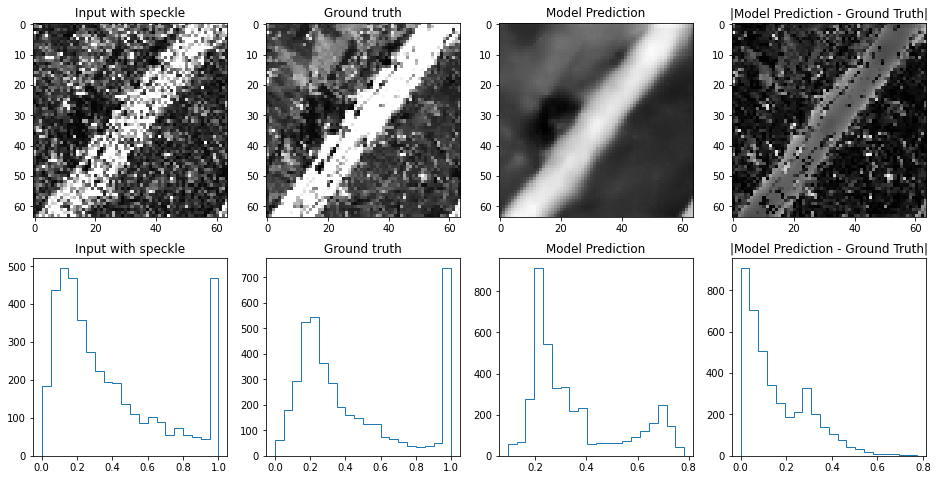

-------------------------------------------------------------------------------------------
Test 20


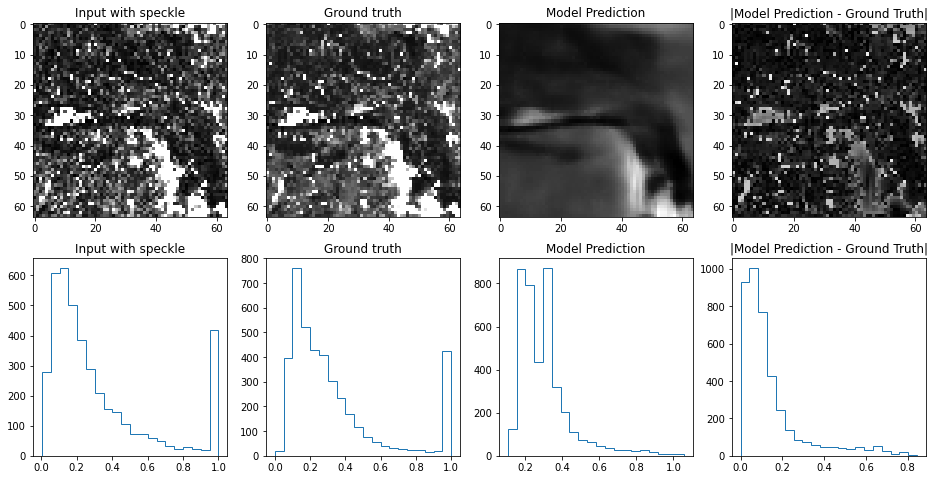

-------------------------------------------------------------------------------------------
Test 21


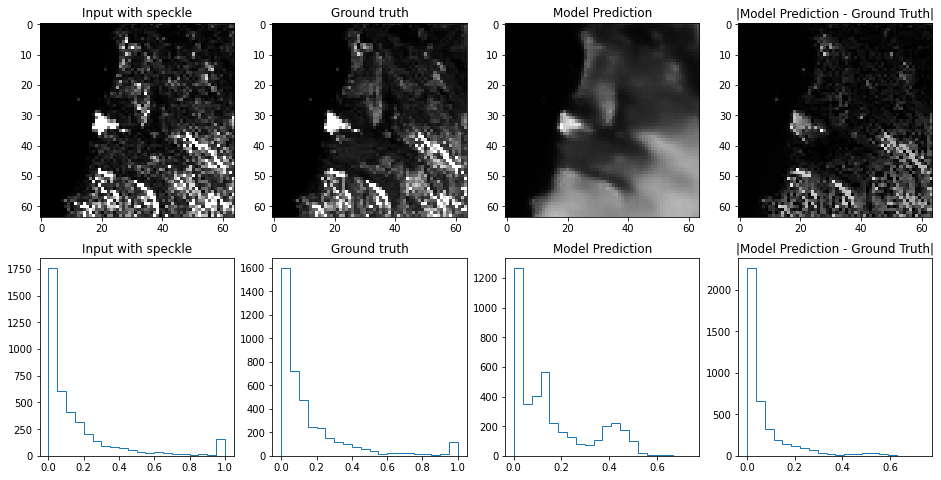

-------------------------------------------------------------------------------------------
Test 22


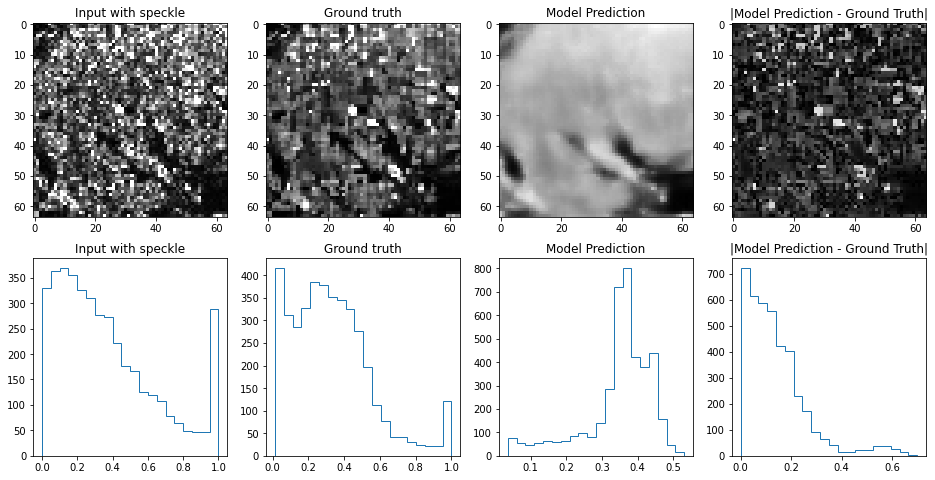

-------------------------------------------------------------------------------------------
Test 23


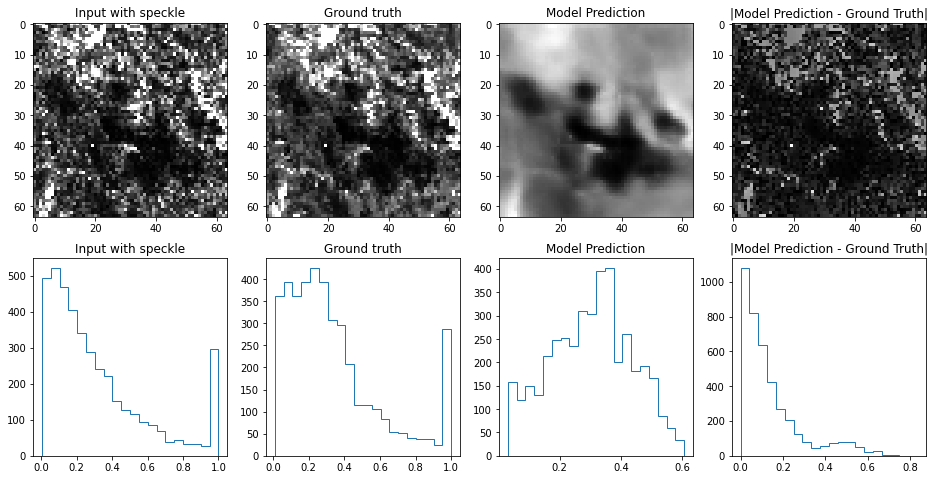

-------------------------------------------------------------------------------------------
Test 24


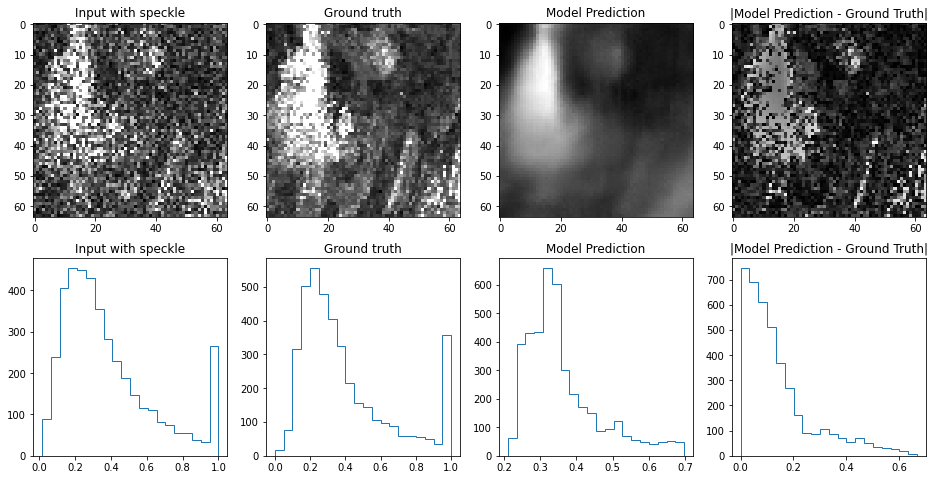

-------------------------------------------------------------------------------------------
Test 25


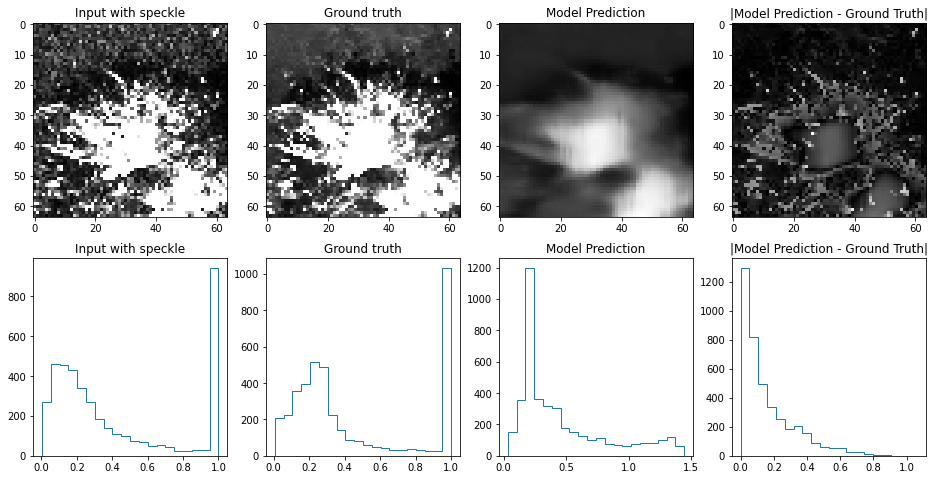

-------------------------------------------------------------------------------------------
Test 26


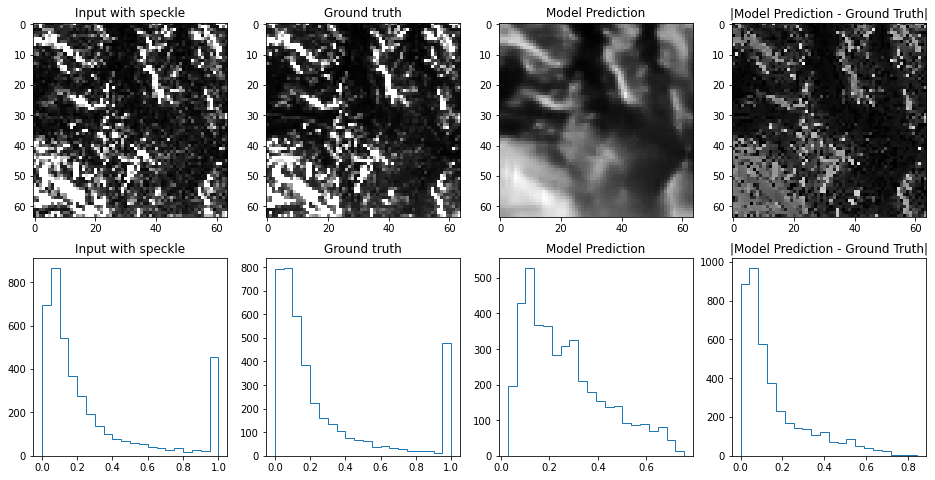

-------------------------------------------------------------------------------------------
Test 27


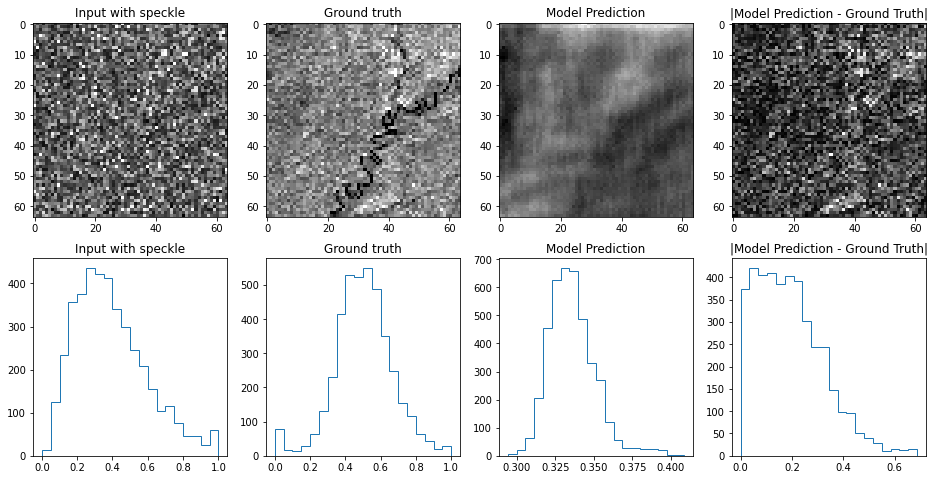

-------------------------------------------------------------------------------------------
Test 28


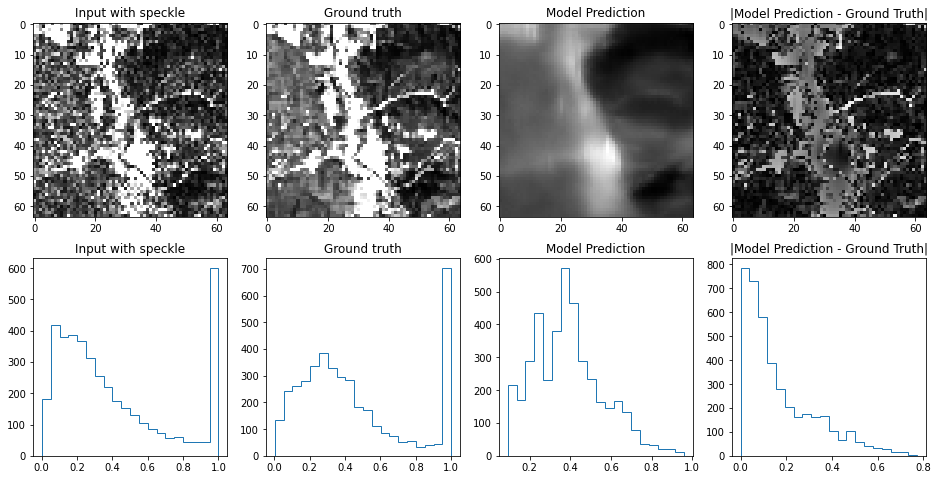

-------------------------------------------------------------------------------------------
Test 29


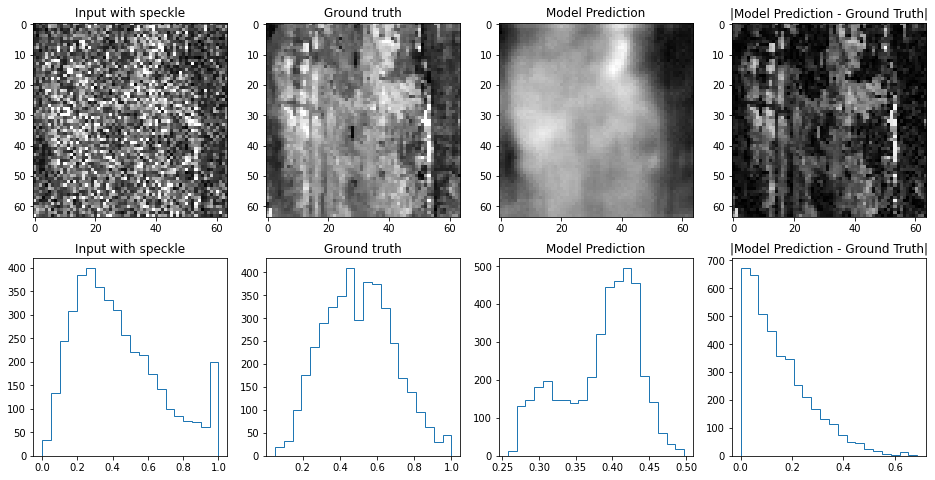

-------------------------------------------------------------------------------------------
Test 30


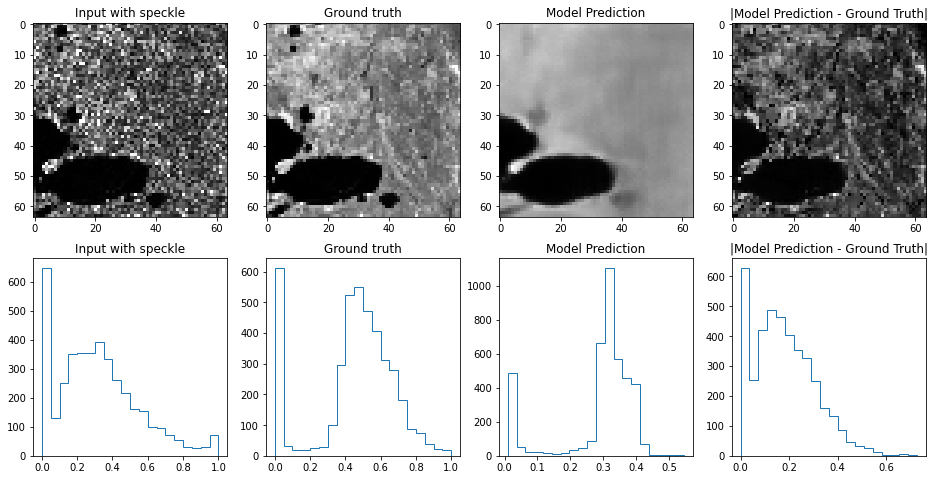

-------------------------------------------------------------------------------------------
Test 31


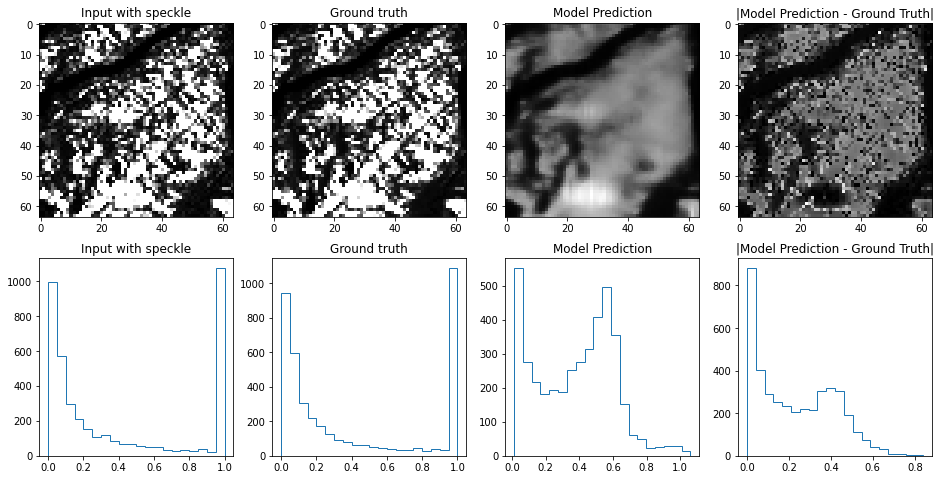

-------------------------------------------------------------------------------------------
Test 32


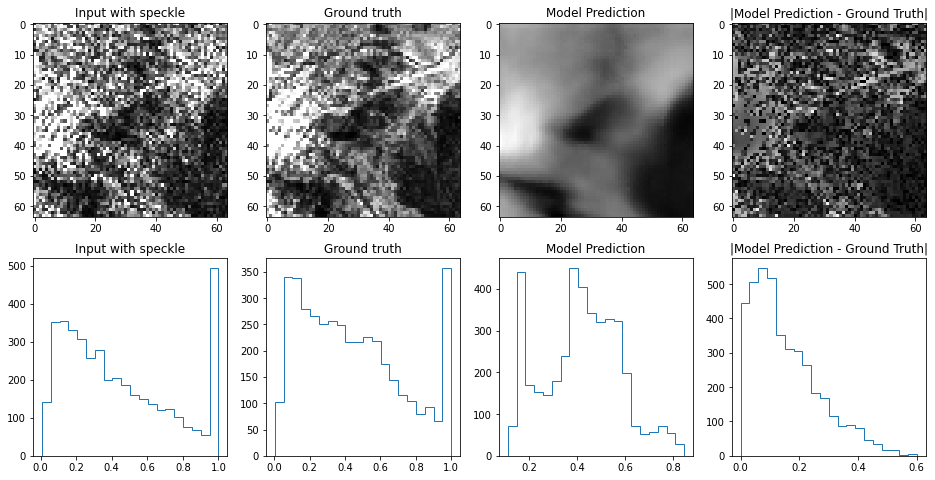

-------------------------------------------------------------------------------------------
Test 33


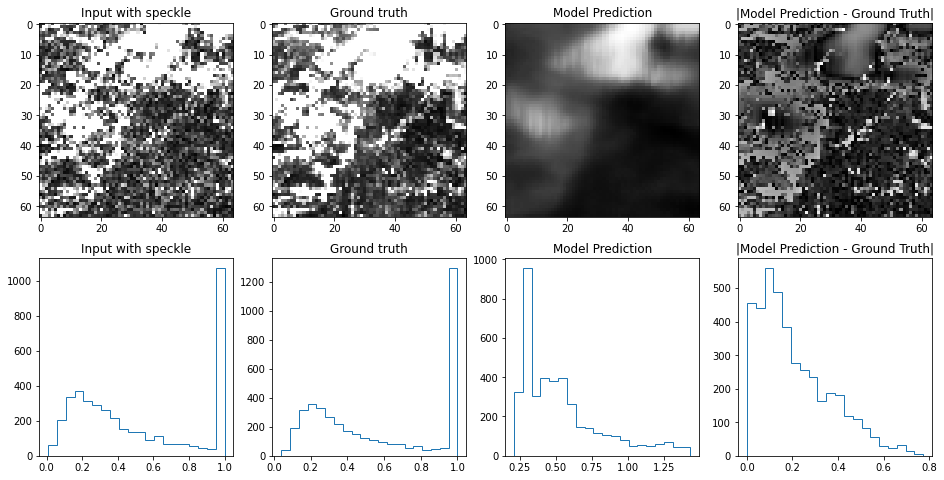

-------------------------------------------------------------------------------------------
Test 34


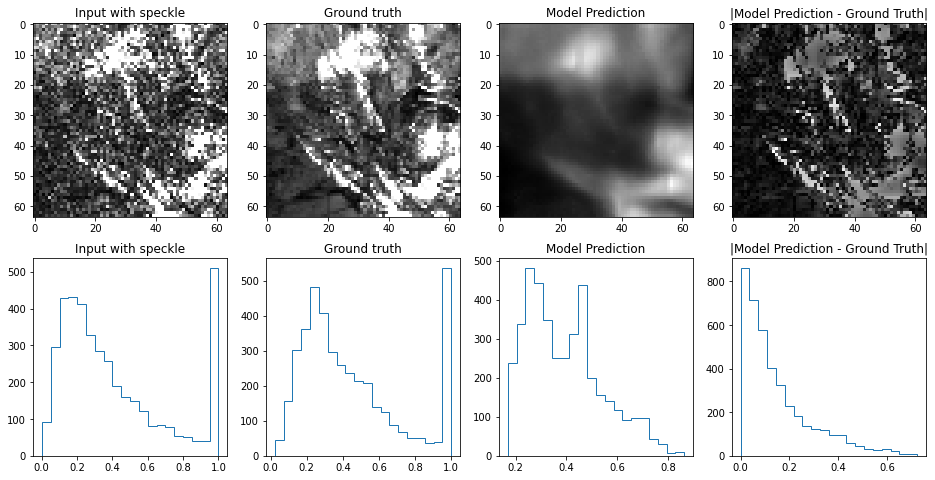

-------------------------------------------------------------------------------------------
Test 35


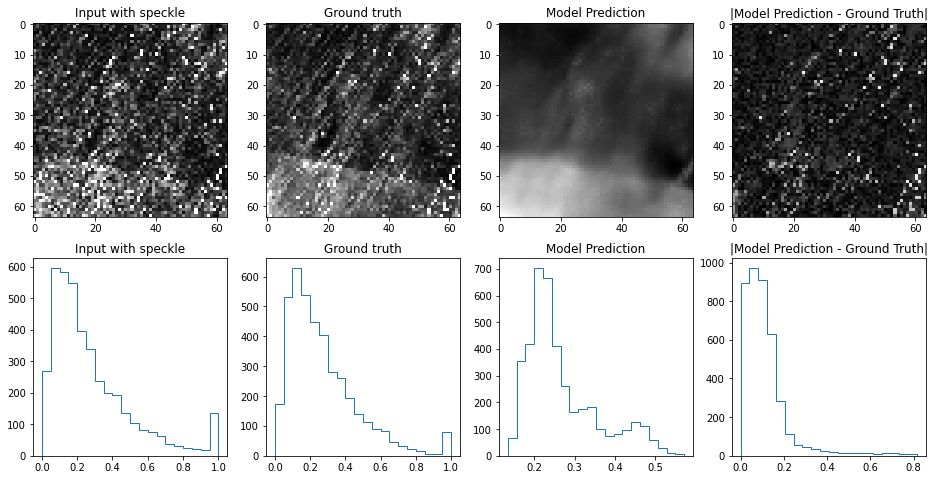

-------------------------------------------------------------------------------------------
Test 36


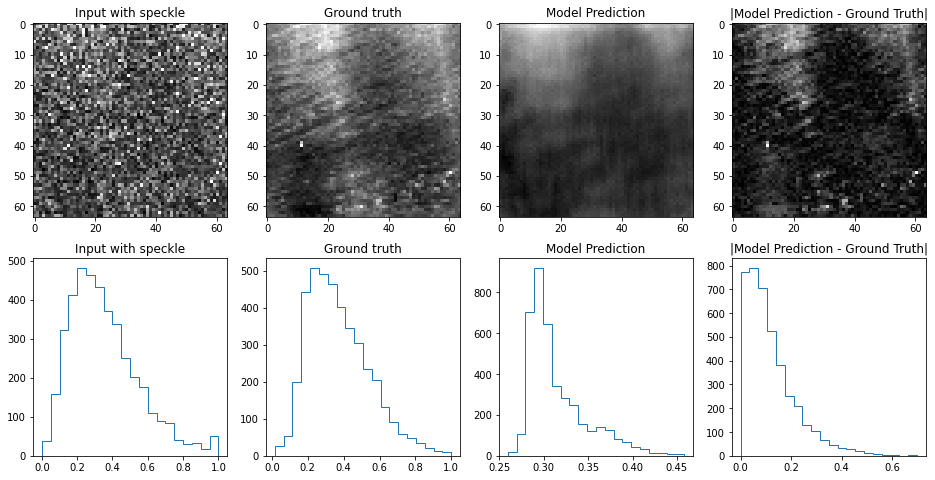

In [16]:
plot_model_results(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], batch_pred[:,:64,:64,...])

In [18]:
compute_metrics(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], batch_pred[:,:64,:64,...])

  Test 		 Metric		Grount Truth VS Grount Truth 		 Grount Truth VS Input 		 Grount Truth VS Model Prediction
-------------------------------------------------------------------------------------------------------------------------------------------
   0  		  PSNR 		             inf             		             14.14      		             14.02
   0  		  SSIM 		             1.00             		             0.55      		             0.13
   0  		  ENL  		             3.70             		             2.17      		             19.45
-------------------------------------------------------------------------------------------------------------------------------------------
   1  		  PSNR 		             inf             		             15.03      		             12.36
   1  		  SSIM 		             1.00             		             0.70      		             0.11
   1  		  ENL  		             2.27             		             1.77      		             20.37
--------------------------------------------------------

# SAR2SAR

In [13]:

IMG_SHAPE = (256,256,1)

In [14]:
batch_speckle, batch_clean = handler.data_loader_v2(
    paths      = handler.test_paths, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN)

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from model import denoiser


with tf.Session() as sess:
    model = denoiser(sess)
    model.load('SAR2SAR-GRD-test/checkpoint')
    Y_ = tf.placeholder(tf.float32, [None, None, None, 1],
                                 name='clean_image')
    pred = sess.run([model.Y], feed_dict={model.Y_: batch_speckle})

/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '


[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from SAR2SAR-GRD-test/checkpoint/SAR2SAR-tensorflow-101940


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key denoising_network/conv_comb_0/W not found in checkpoint
	 [[node save_1/RestoreV2 (defined at SAR2SAR-GRD-test/model.py:17) ]]

Original stack trace for 'save_1/RestoreV2':
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
    user_expressions, allow_stdin,
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-619724981895>", line 8, in <module>
    model.load('SAR2SAR-GRD-test/checkpoint')
  File "SAR2SAR-GRD-test/model.py", line 17, in load
    saver = tf.train.Saver()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 836, in __init__
    self.build()
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 848, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in _build
    build_restore=build_restore)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 516, in _build_internal
    restore_sequentially, reshape)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 336, in _AddRestoreOps
    restore_sequentially)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 583, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1493, in restore_v2
    name=name)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 750, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3565, in _create_op_internal
    op_def=op_def)
  File "/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


-------------------------------------------------------------------------------------------
Test 0


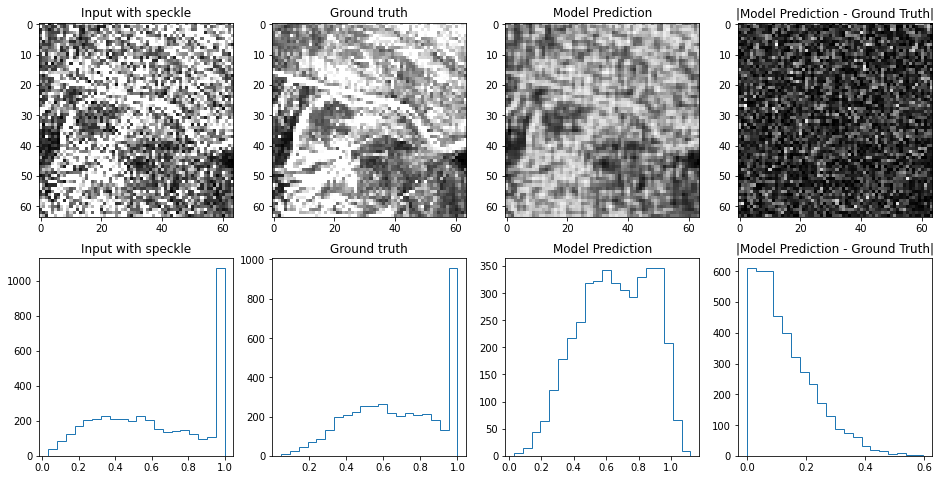

-------------------------------------------------------------------------------------------
Test 1


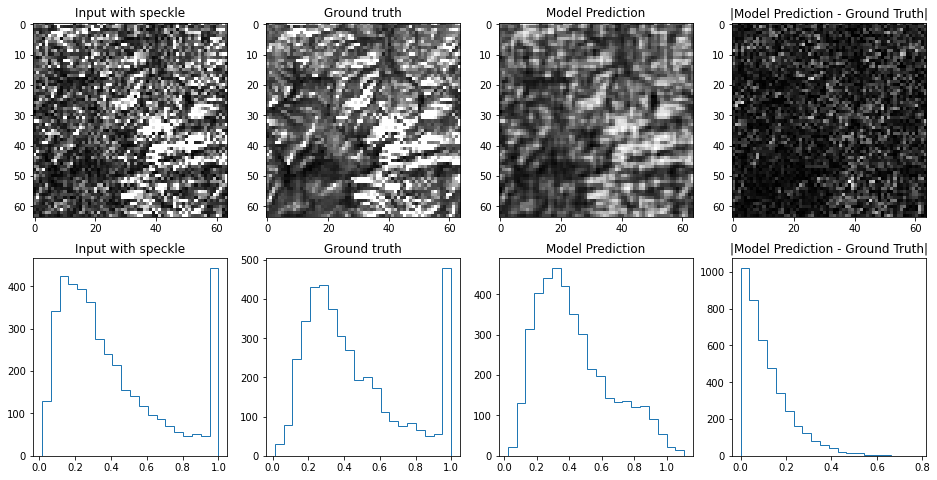

-------------------------------------------------------------------------------------------
Test 2


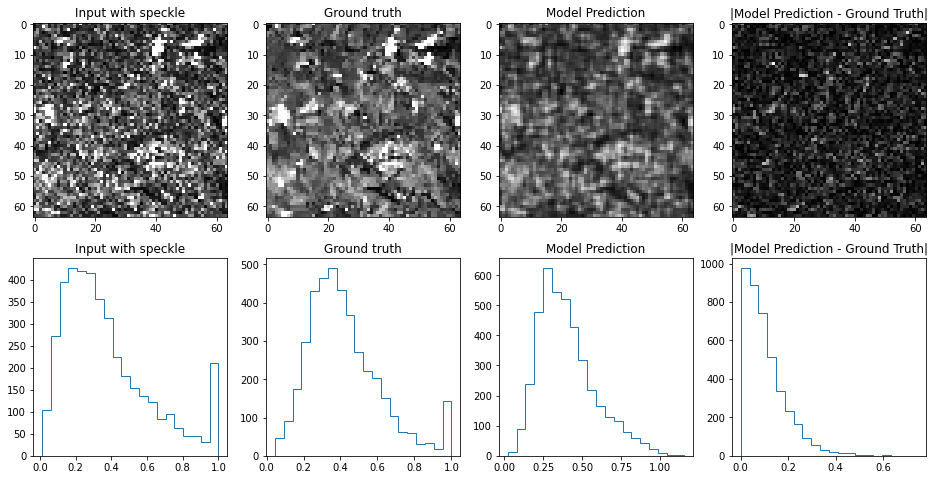

-------------------------------------------------------------------------------------------
Test 3


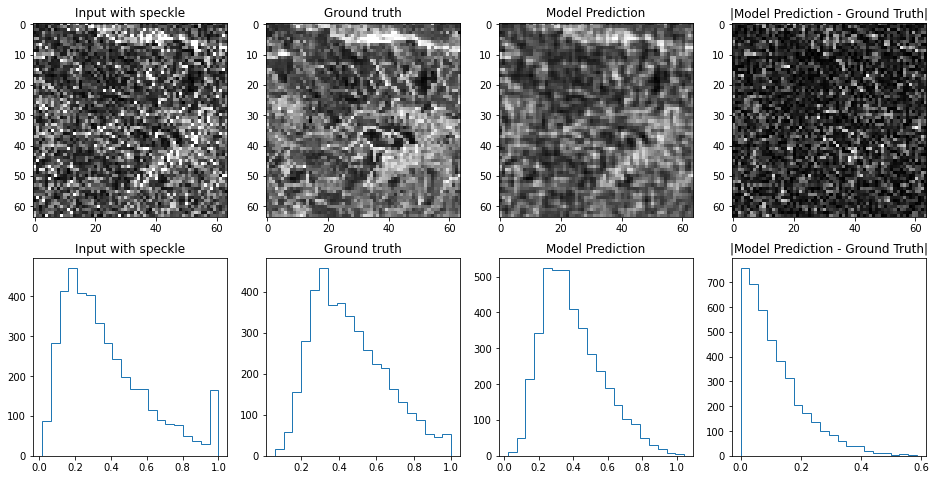

-------------------------------------------------------------------------------------------
Test 4


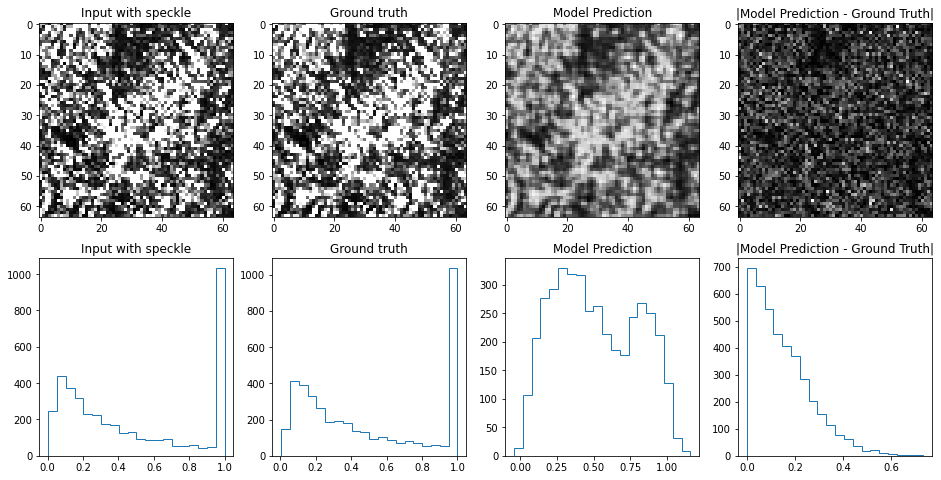

-------------------------------------------------------------------------------------------
Test 5


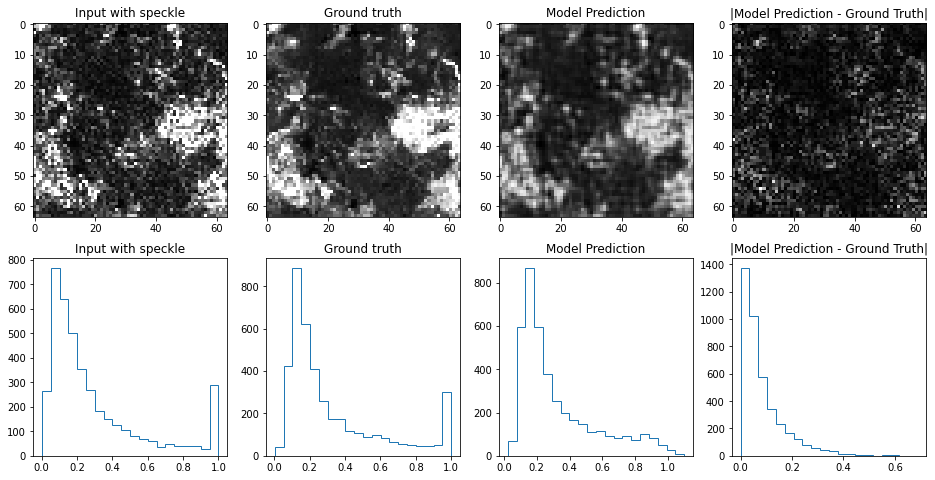

-------------------------------------------------------------------------------------------
Test 6


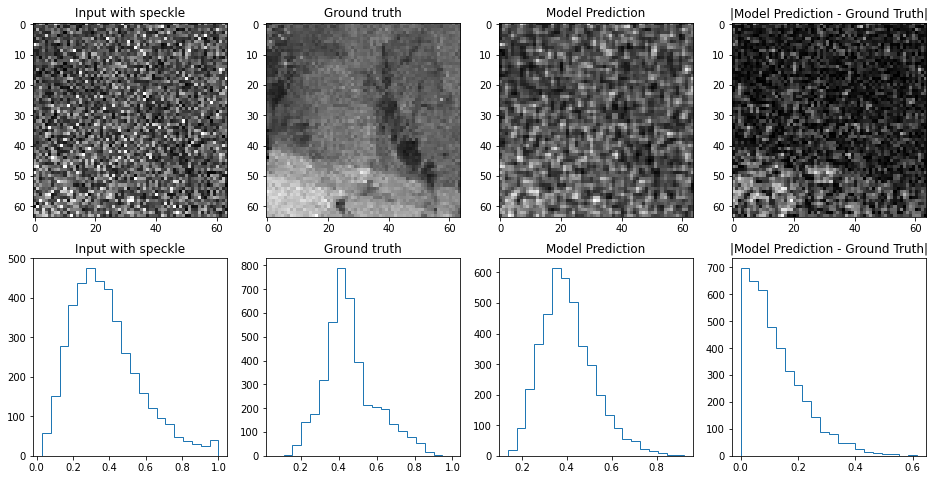

-------------------------------------------------------------------------------------------
Test 7


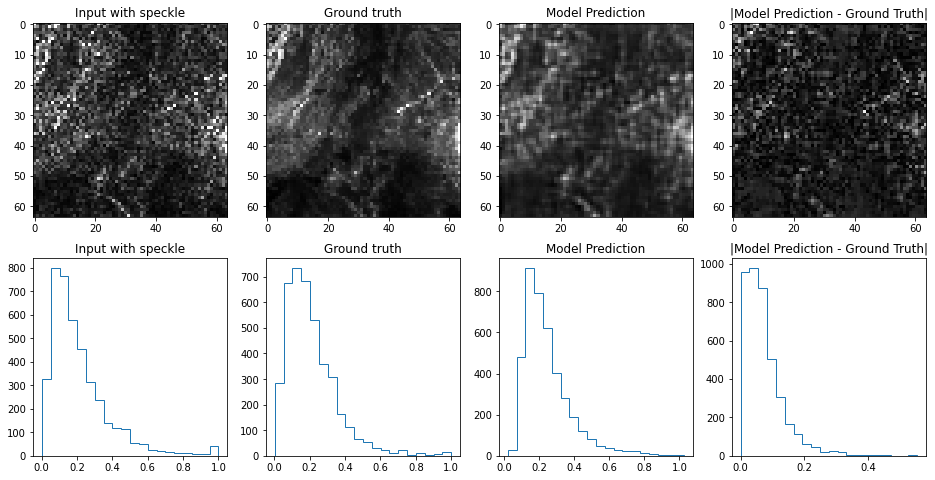

-------------------------------------------------------------------------------------------
Test 8


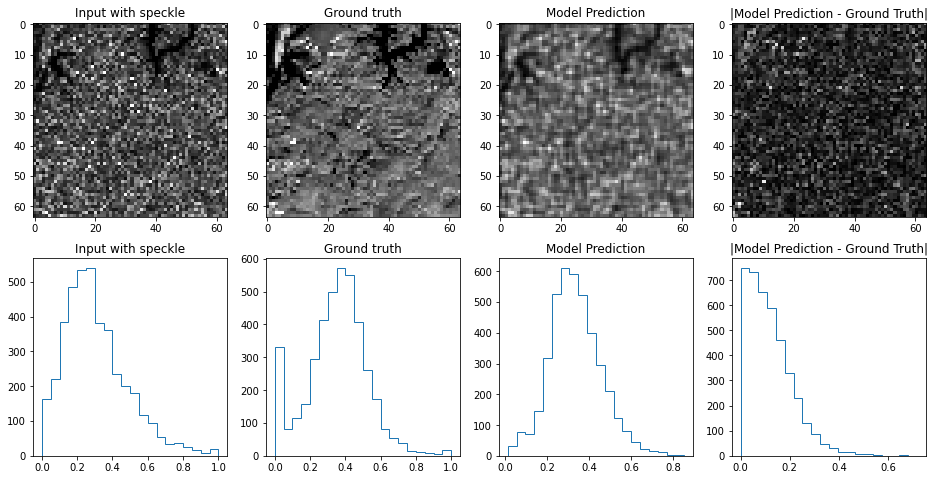

-------------------------------------------------------------------------------------------
Test 9


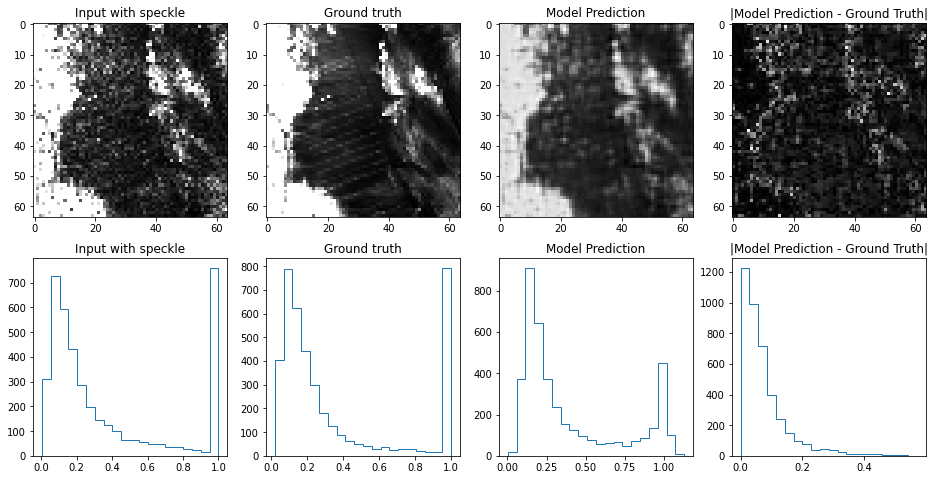

-------------------------------------------------------------------------------------------
Test 10


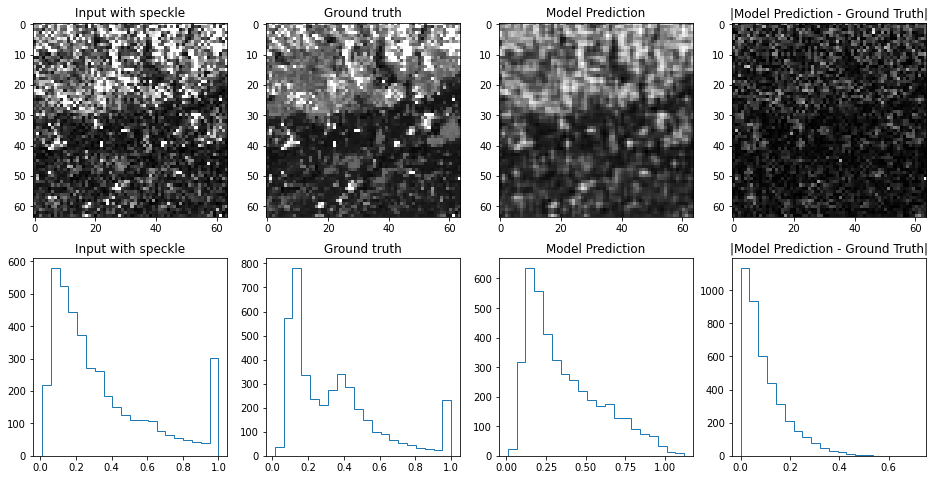

-------------------------------------------------------------------------------------------
Test 11


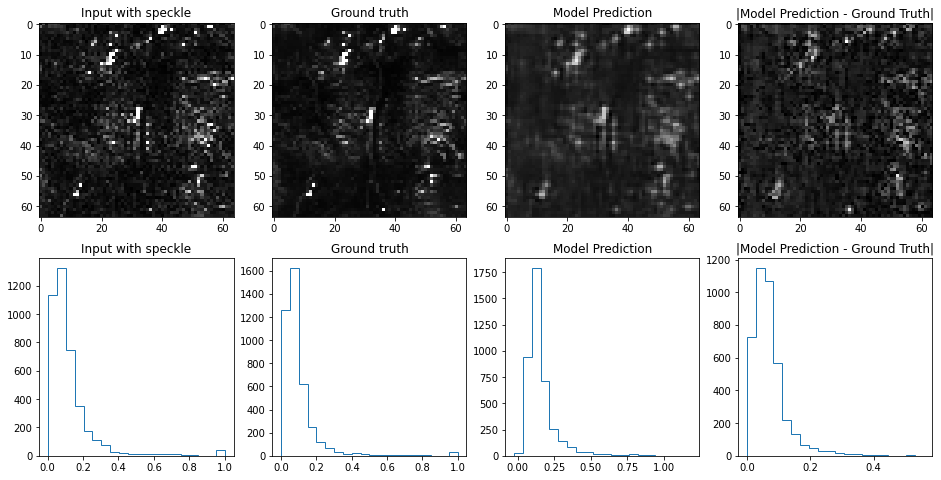

-------------------------------------------------------------------------------------------
Test 12


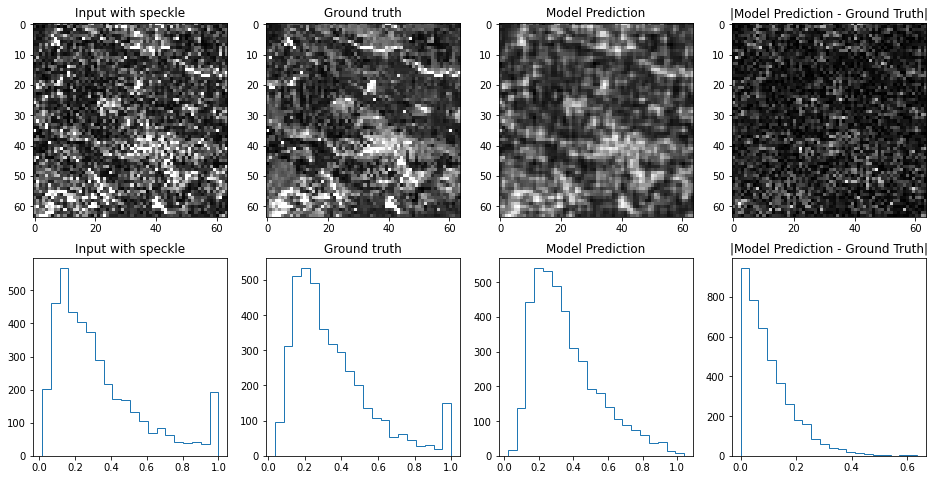

-------------------------------------------------------------------------------------------
Test 13


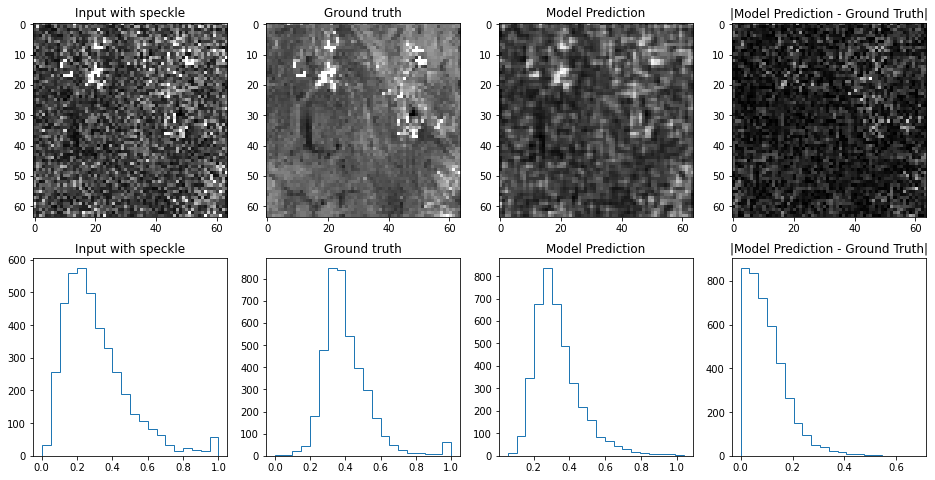

-------------------------------------------------------------------------------------------
Test 14


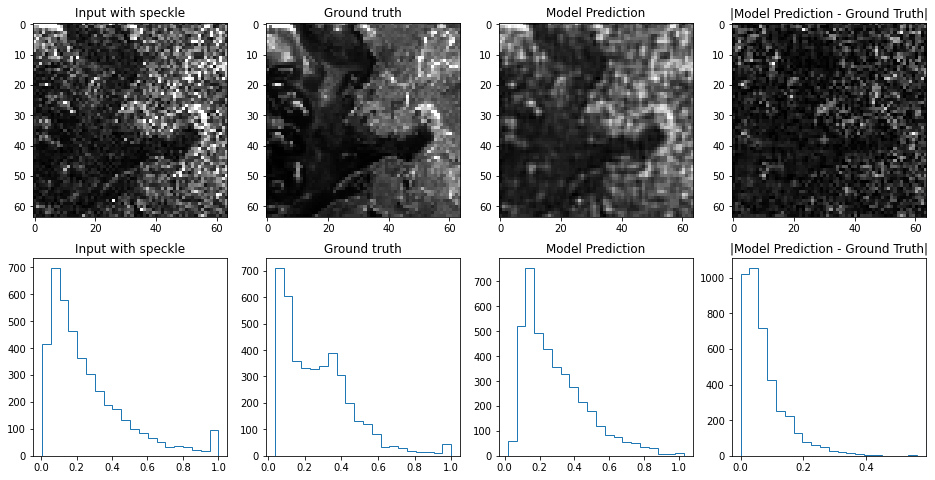

-------------------------------------------------------------------------------------------
Test 15


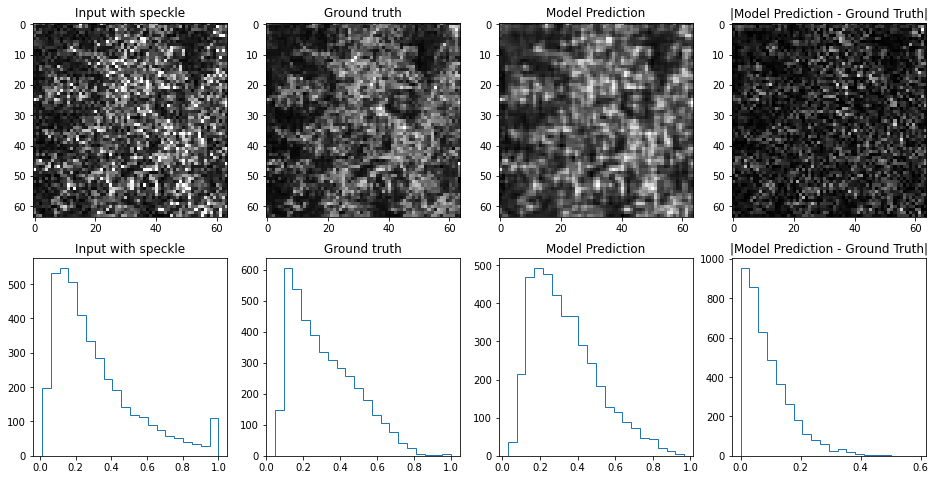

-------------------------------------------------------------------------------------------
Test 16


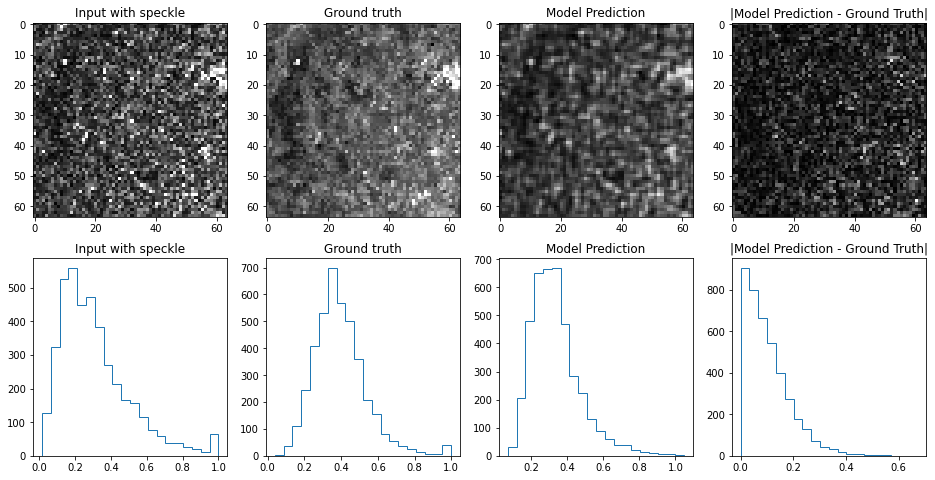

-------------------------------------------------------------------------------------------
Test 17


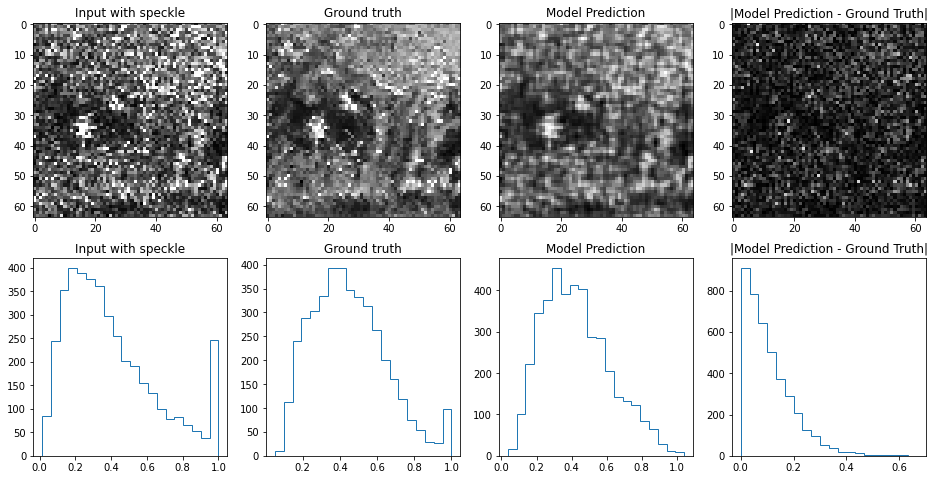

-------------------------------------------------------------------------------------------
Test 18


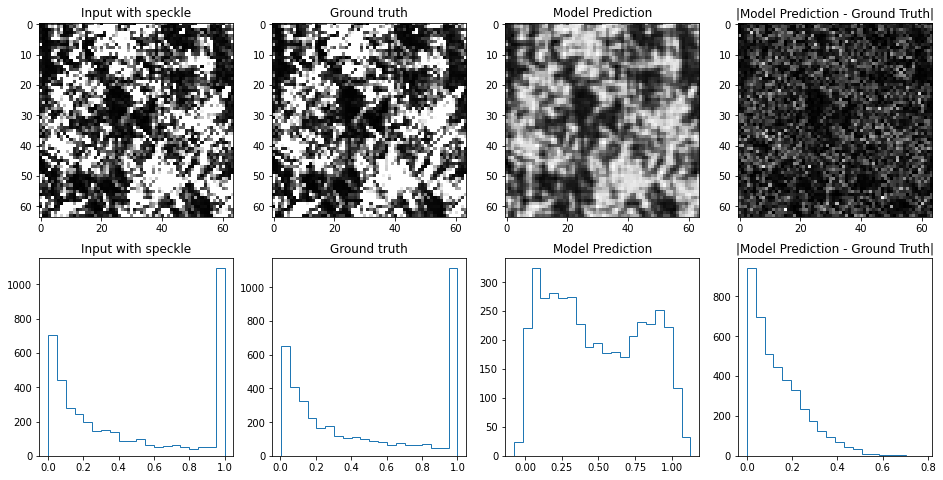

-------------------------------------------------------------------------------------------
Test 19


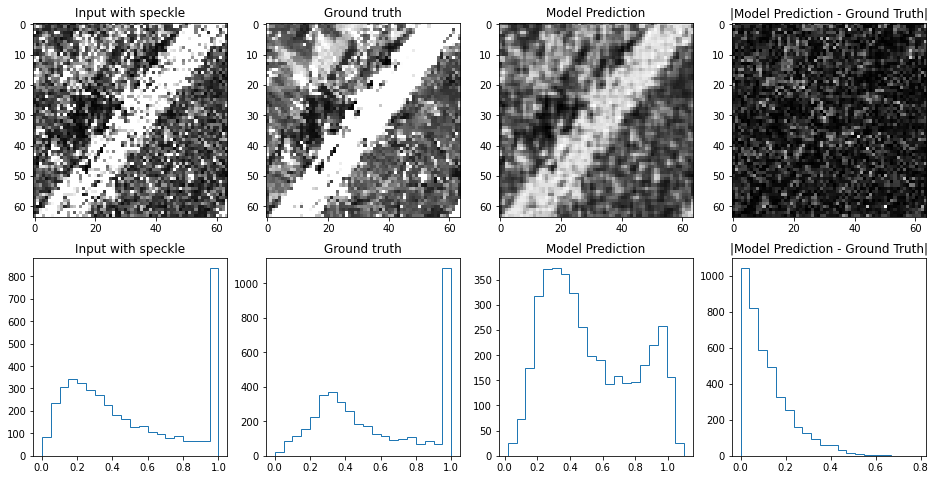

-------------------------------------------------------------------------------------------
Test 20


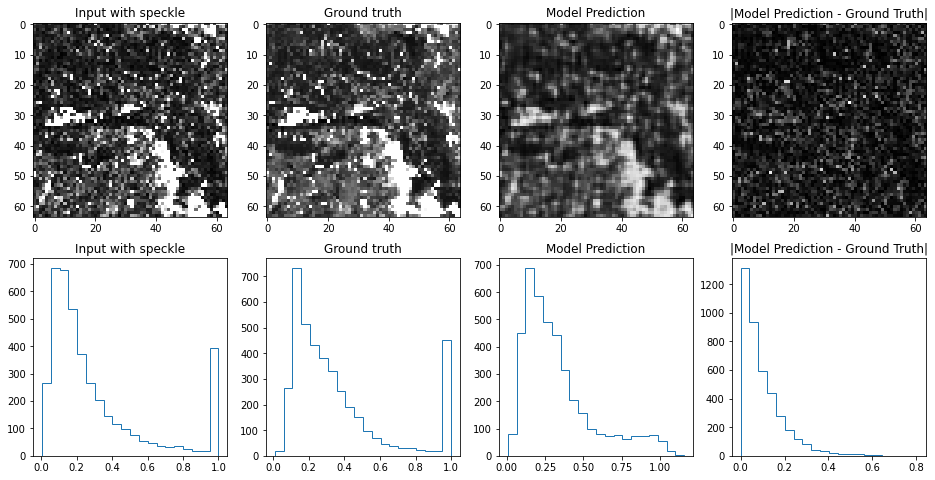

-------------------------------------------------------------------------------------------
Test 21


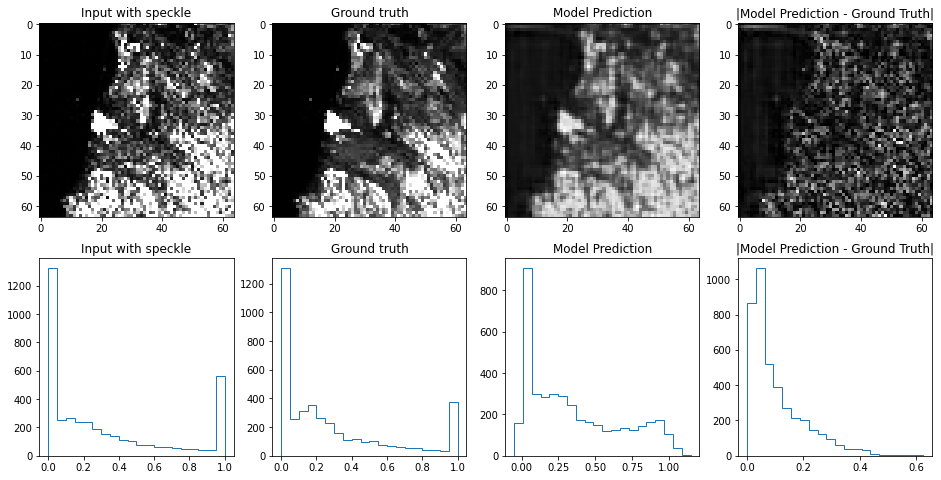

-------------------------------------------------------------------------------------------
Test 22


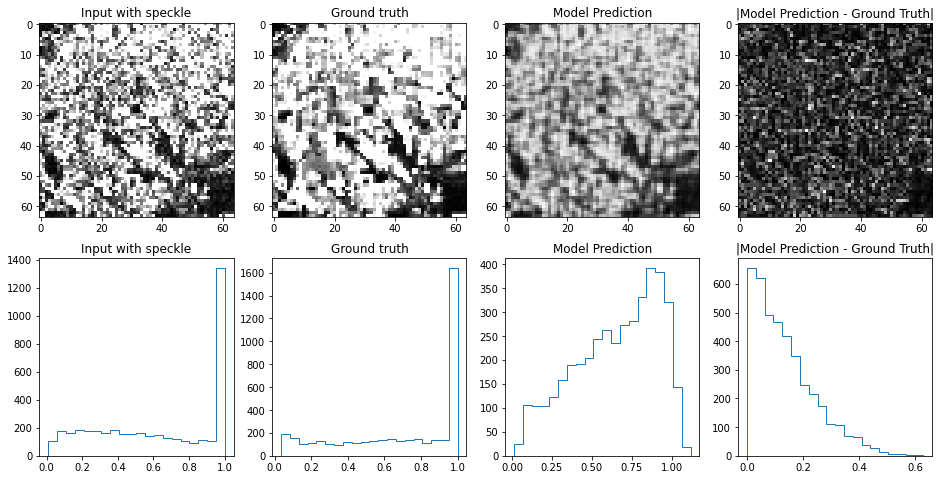

-------------------------------------------------------------------------------------------
Test 23


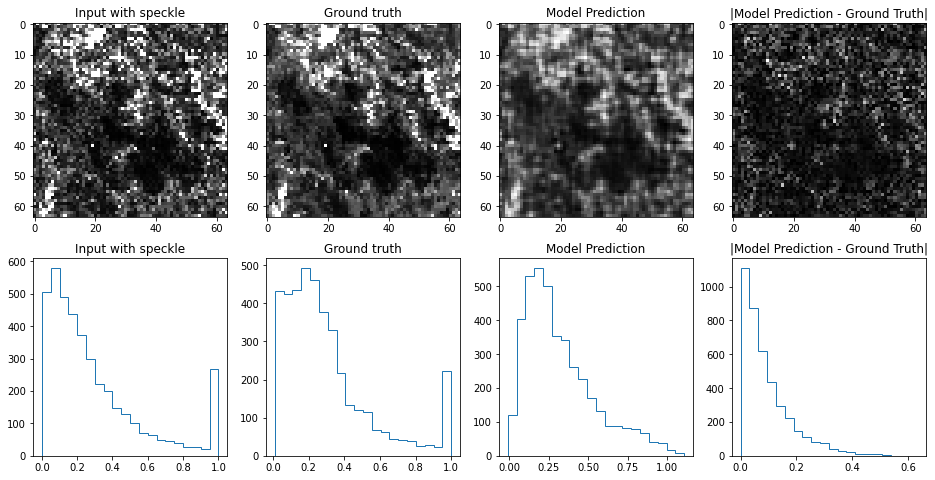

-------------------------------------------------------------------------------------------
Test 24


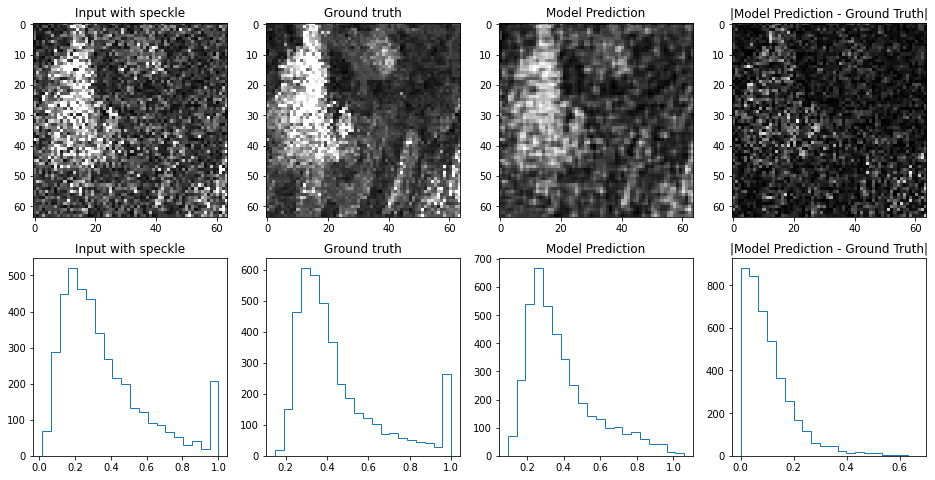

-------------------------------------------------------------------------------------------
Test 25


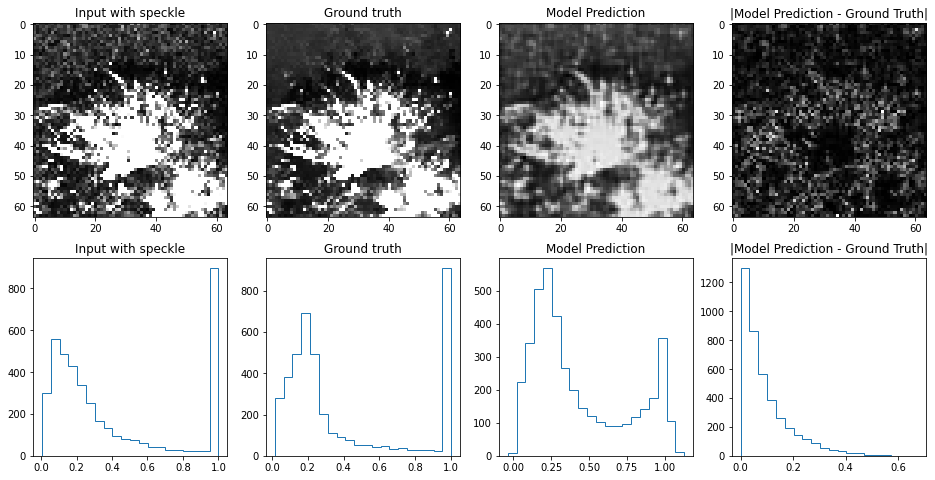

-------------------------------------------------------------------------------------------
Test 26


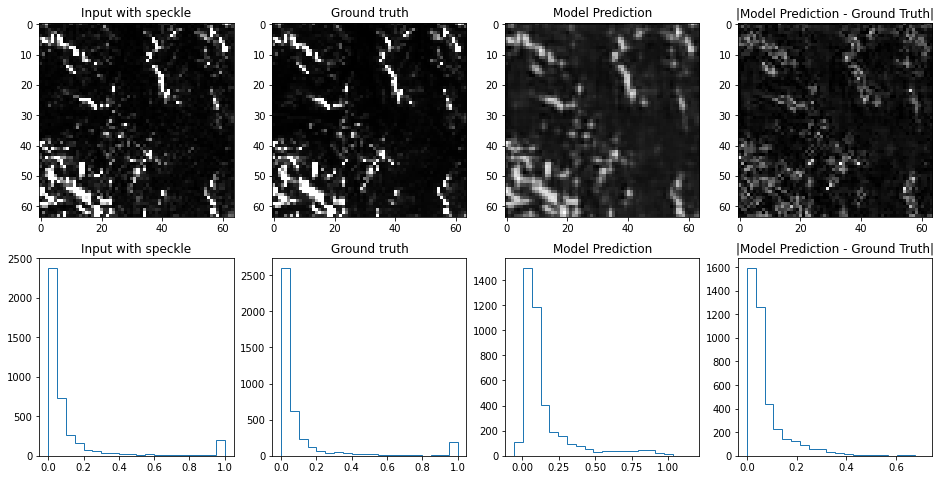

-------------------------------------------------------------------------------------------
Test 27


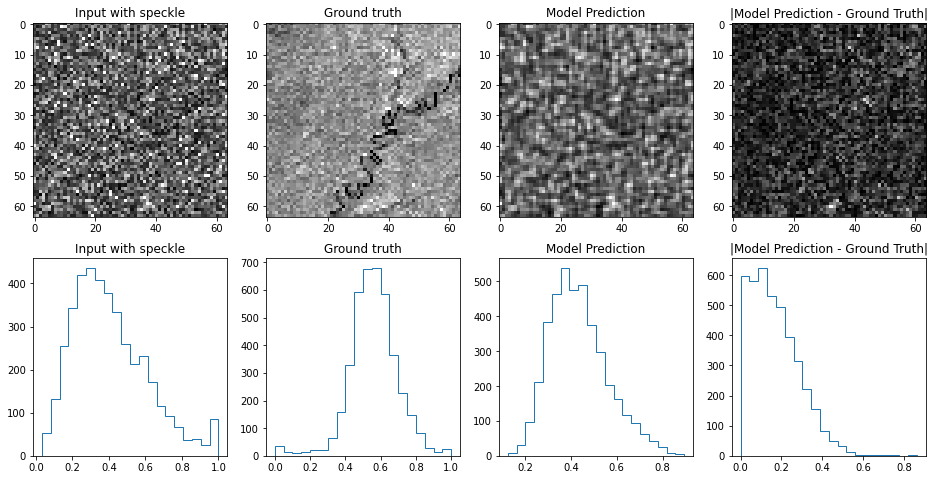

-------------------------------------------------------------------------------------------
Test 28


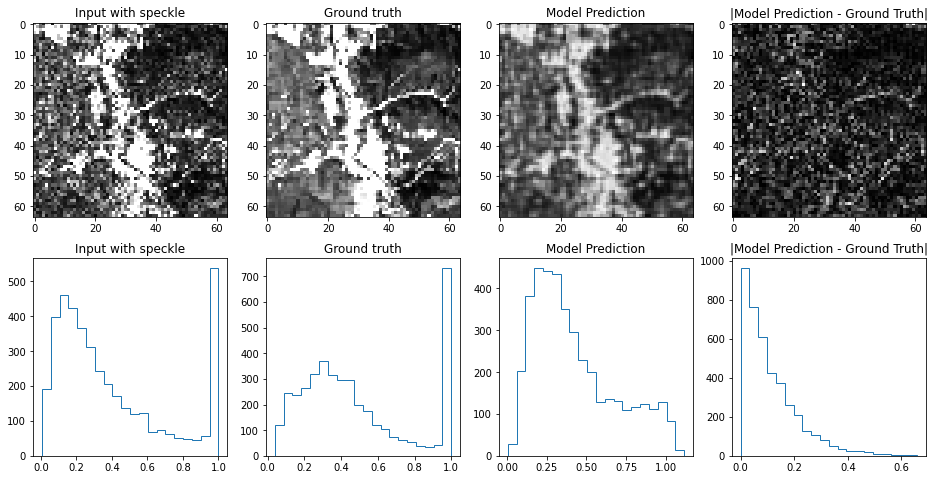

-------------------------------------------------------------------------------------------
Test 29


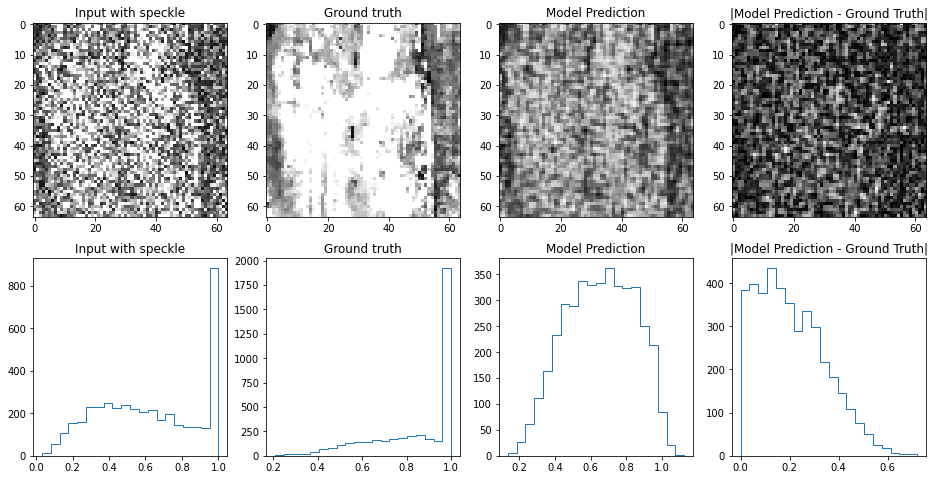

-------------------------------------------------------------------------------------------
Test 30


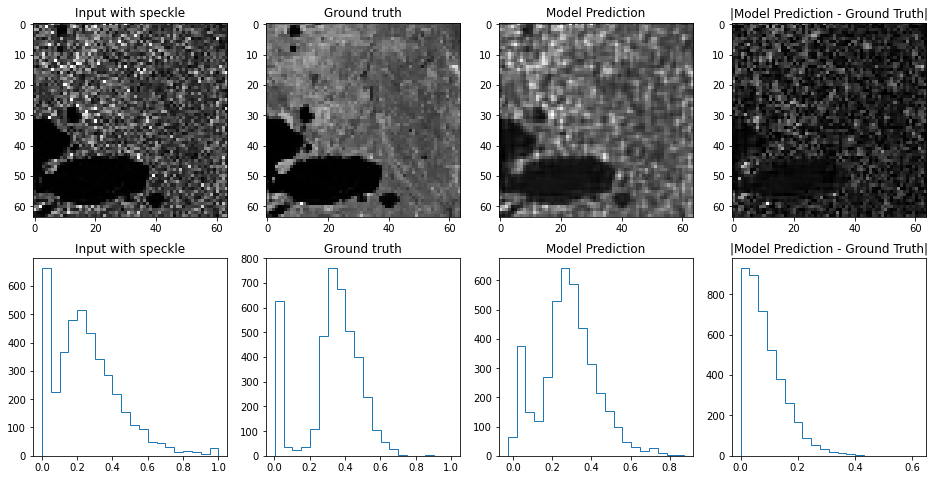

-------------------------------------------------------------------------------------------
Test 31


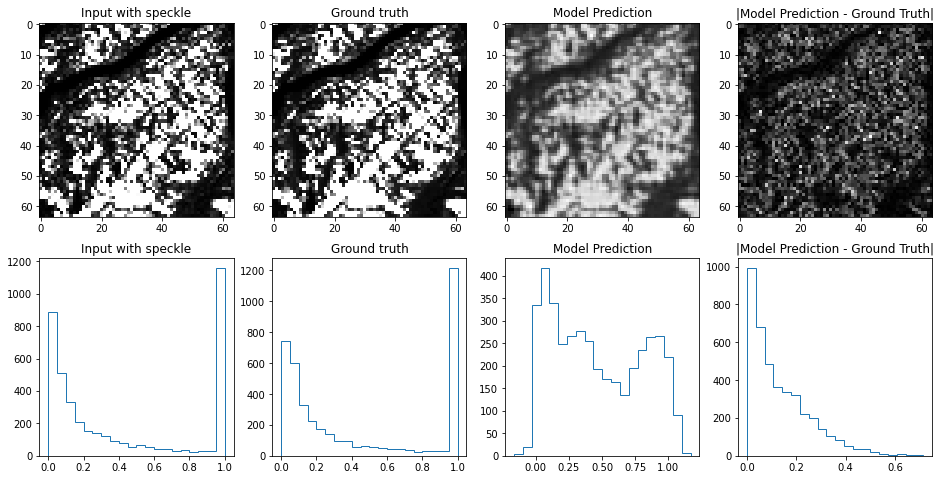

-------------------------------------------------------------------------------------------
Test 32


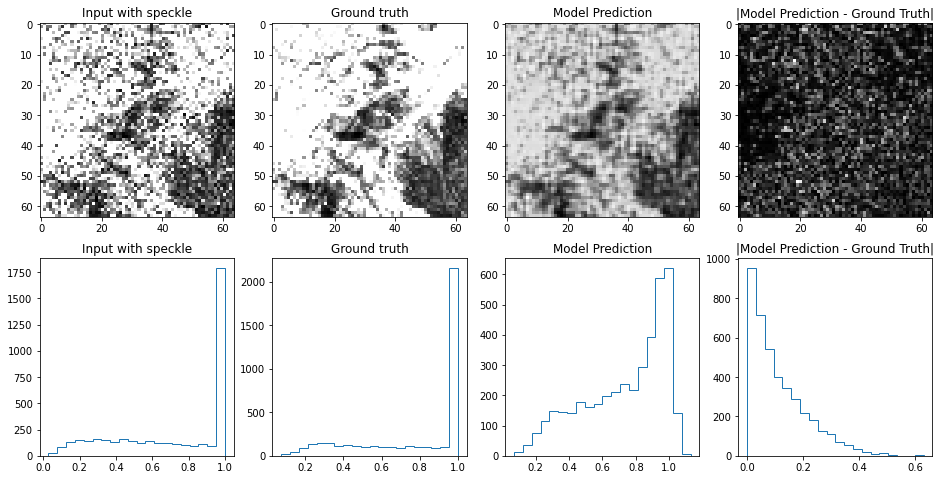

-------------------------------------------------------------------------------------------
Test 33


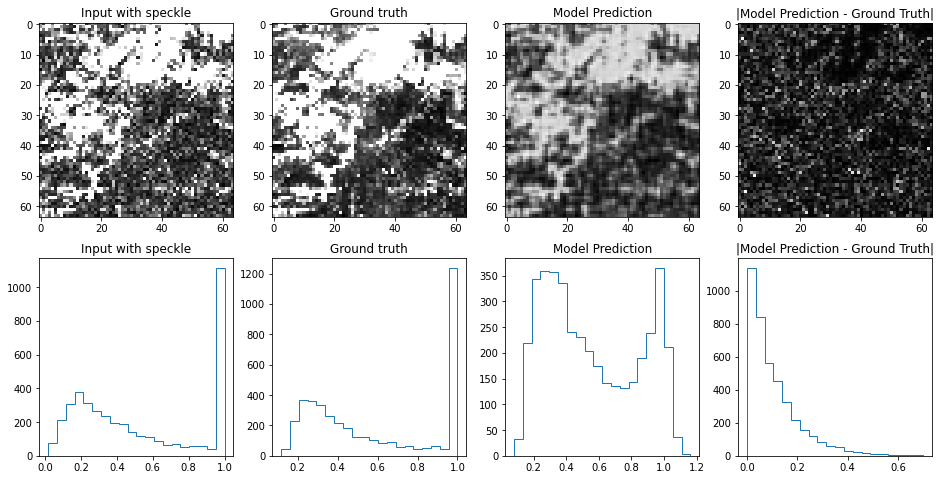

-------------------------------------------------------------------------------------------
Test 34


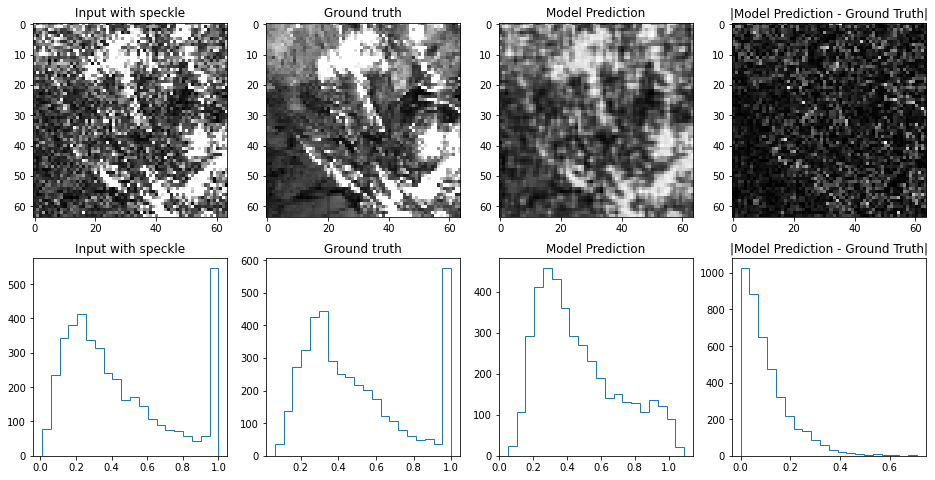

-------------------------------------------------------------------------------------------
Test 35


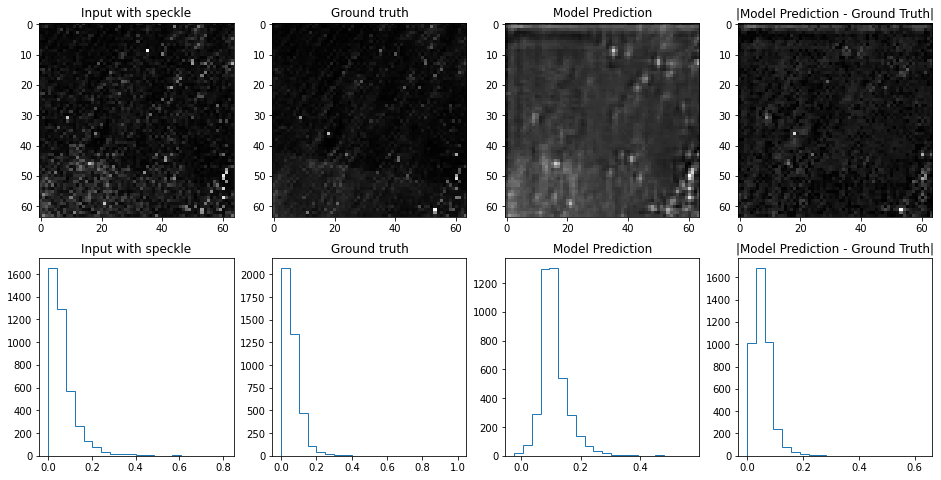

-------------------------------------------------------------------------------------------
Test 36


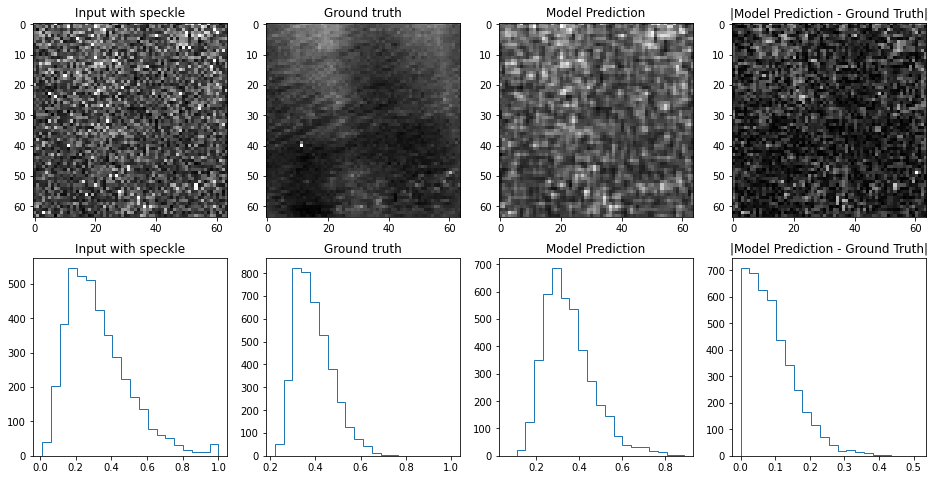

  Test 		 Metric		Grount Truth VS Grount Truth 		 Grount Truth VS Input 		 Grount Truth VS Model Prediction
-------------------------------------------------------------------------------------------------------------------------------------------
   0  		  PSNR 		             inf             		             12.73      		             15.67
   0  		  SSIM 		             1.00             		             0.53      		             0.60
   0  		  ENL  		             7.52             		             4.40      		             9.02
-------------------------------------------------------------------------------------------------------------------------------------------
   1  		  PSNR 		             inf             		             14.50      		             16.07
   1  		  SSIM 		             1.00             		             0.71      		             0.73
   1  		  ENL  		             2.81             		             1.93      		             3.66
----------------------------------------------------------

/Users/alessandrosebastianelli/Desktop/CNNSpeckleFilter/filterenv/lib/python3.6/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


In [11]:
plot_model_results(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], pred[0][:,:64,:64,...])
compute_metrics(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], pred[0][:,:64,:64,...])

# CNN-NLM

In [ ]:
#!pip install git+https://github.com/szagoruyko/pyinn.git@master

In [12]:
sys.path.append('CNN-NLM')
sys.path.append('CNN-NLM/utils')

In [15]:
import models.DnCNN as DnCNN
import pickle
import torch
with open("CNN-NLM/weights/sar_sync/SAR_CNN_e50.pkl", "rb") as fid:
    dncnn_opt = dict(**pickle.load(fid).dncnn)
    dncnn_opt["residual"] = True
net = DnCNN.DnCNN(1, 1, **dncnn_opt)
net.load_state_dict(torch.load('CNN-NLM/weights/sar_sync/SAR_CNN_e50.t7', map_location=torch.device('cpu'))['net'])
pad = 0

def preprocessing_int2net(img):
    return img.abs().log()/2

def postprocessing_net2int(img):
    return (2*img).exp()

In [23]:
out = np.zeros((batch_speckle.shape[0], 64, 64, 1))

for i in range(batch_speckle.shape[0]):
    noise_int  = np.float32((1/256)+batch_speckle[i,:64,:64,0])
    use_cuda = False

    with torch.no_grad():
        if use_cuda:
            net = net.cuda()

        noise_int  = torch.from_numpy(noise_int)[None, None, :, :]   
        #noisy_pad = noise_int**2
        noisy_pad =  preprocessing_int2net(noisy_pad)

        if use_cuda:
            pred_int = net(noisy_pad.cuda()).cpu()
        else:
            pred_int = net(noisy_pad)

        pred_int = postprocessing_net2int(pred_int)
        #pred_amp  = pred_int.abs().sqrt()

        out[i,...,0]  = pred_int[0,0,::].numpy()

-------------------------------------------------------------------------------------------
Test 0


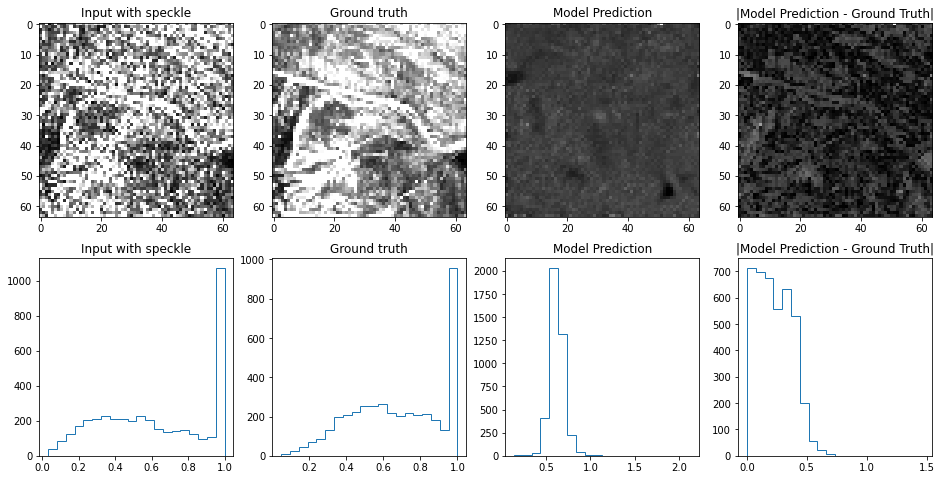

-------------------------------------------------------------------------------------------
Test 1


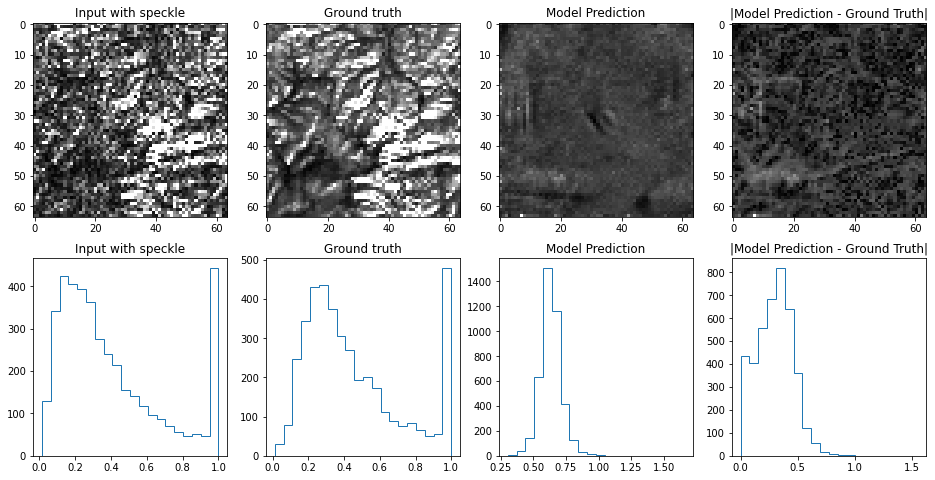

-------------------------------------------------------------------------------------------
Test 2


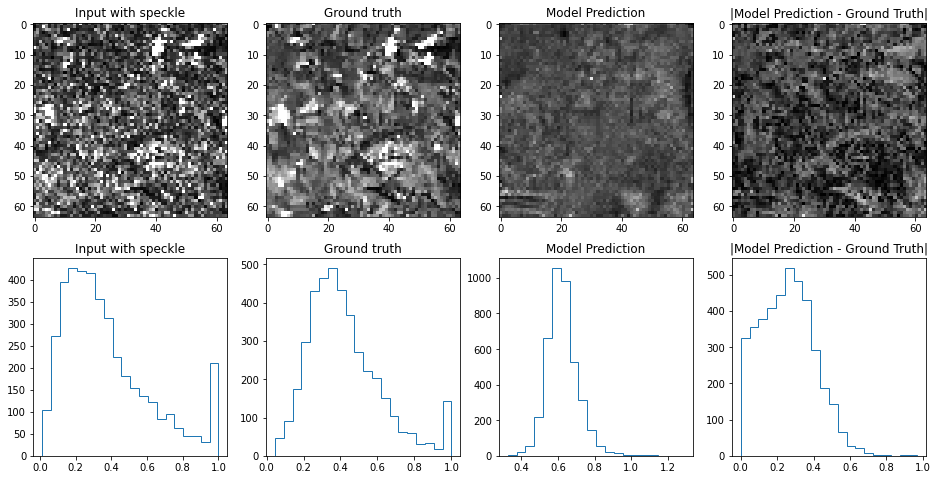

-------------------------------------------------------------------------------------------
Test 3


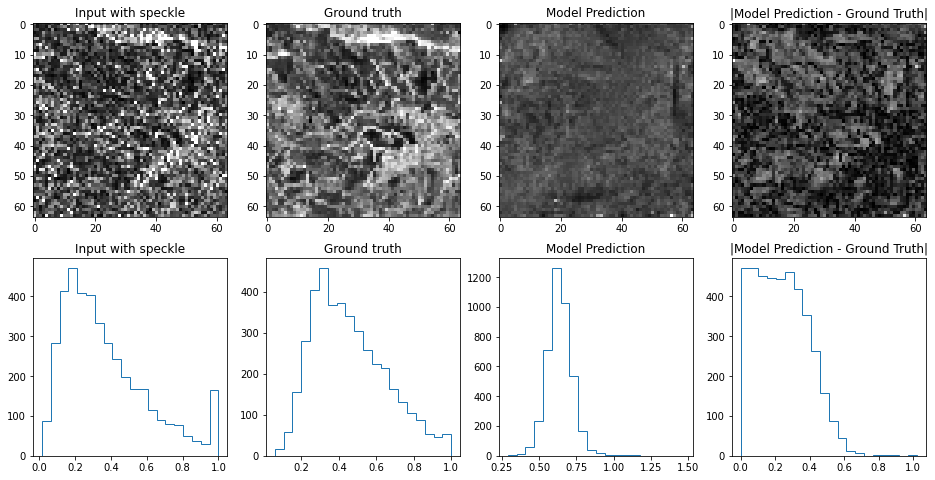

-------------------------------------------------------------------------------------------
Test 4


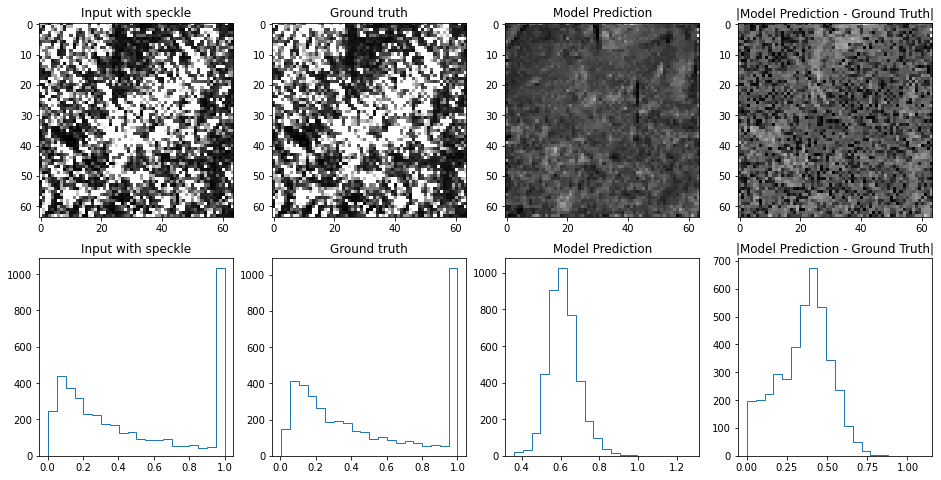

-------------------------------------------------------------------------------------------
Test 5


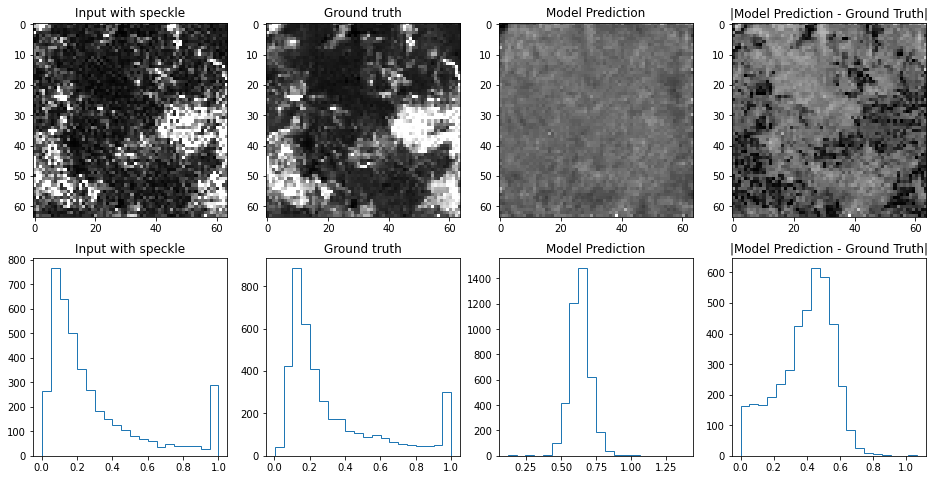

-------------------------------------------------------------------------------------------
Test 6


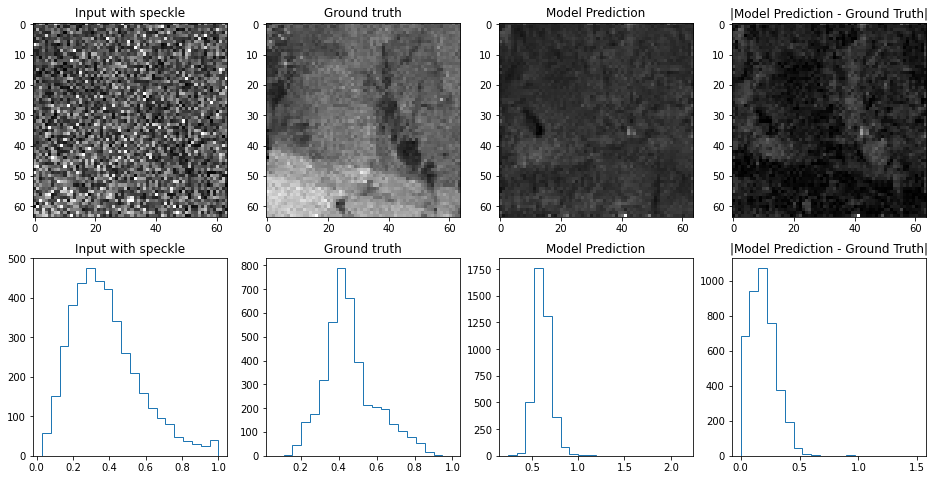

-------------------------------------------------------------------------------------------
Test 7


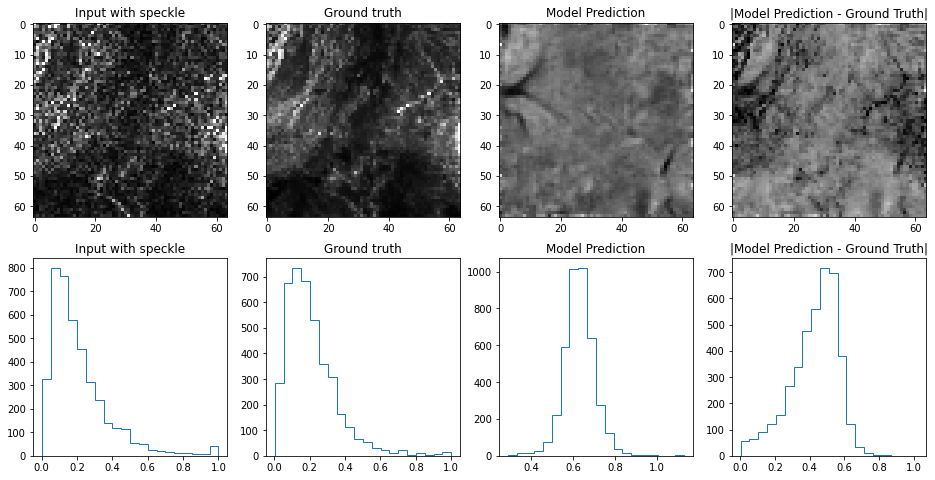

-------------------------------------------------------------------------------------------
Test 8


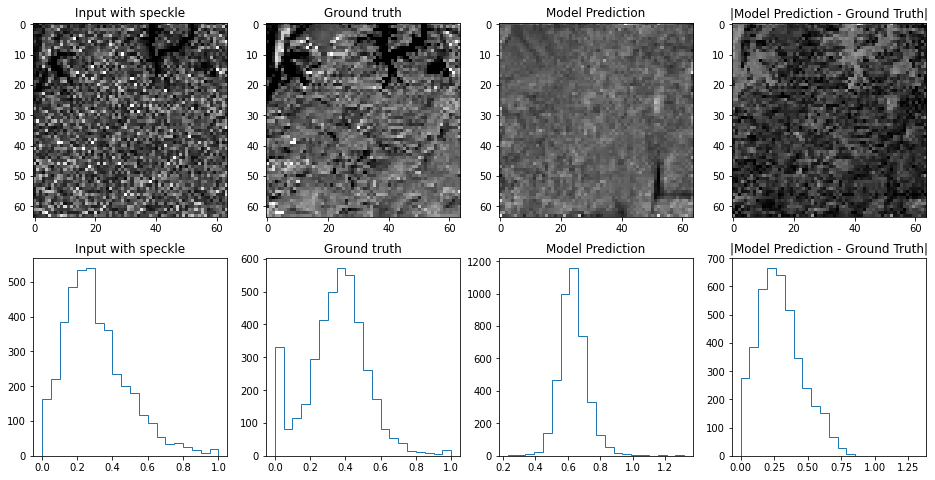

-------------------------------------------------------------------------------------------
Test 9


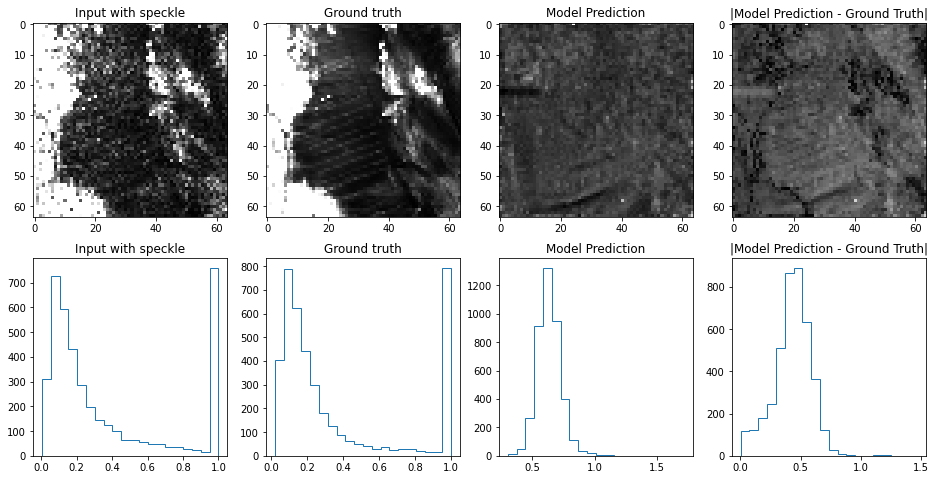

-------------------------------------------------------------------------------------------
Test 10


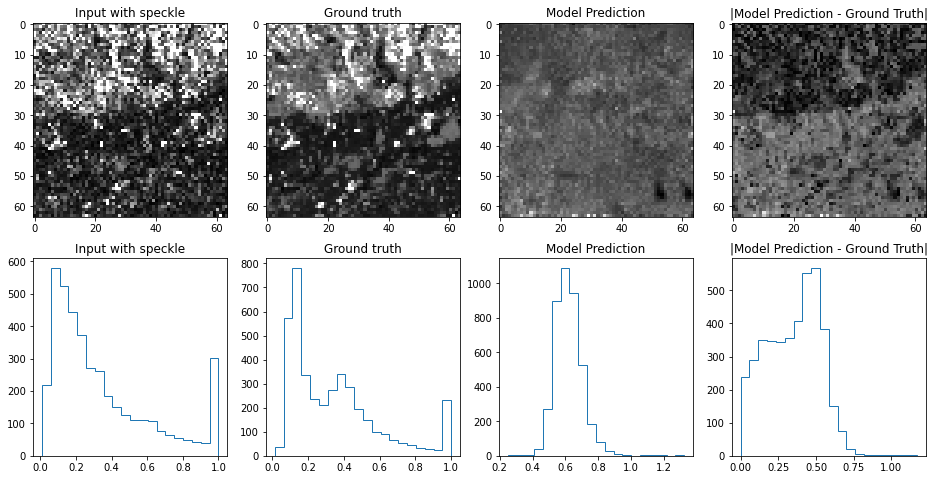

-------------------------------------------------------------------------------------------
Test 11


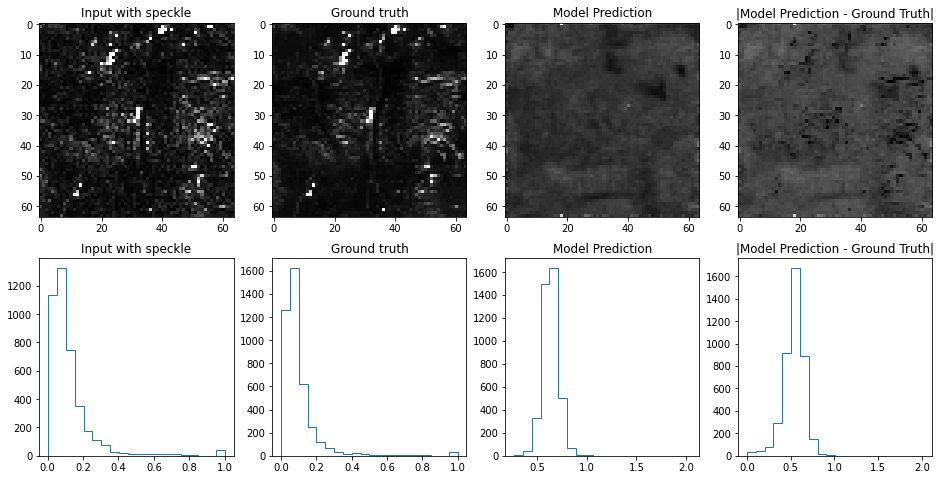

-------------------------------------------------------------------------------------------
Test 12


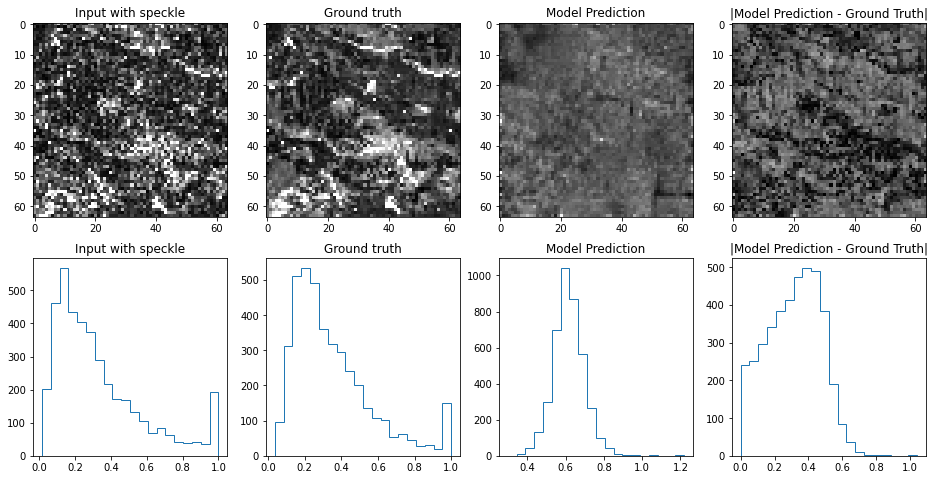

-------------------------------------------------------------------------------------------
Test 13


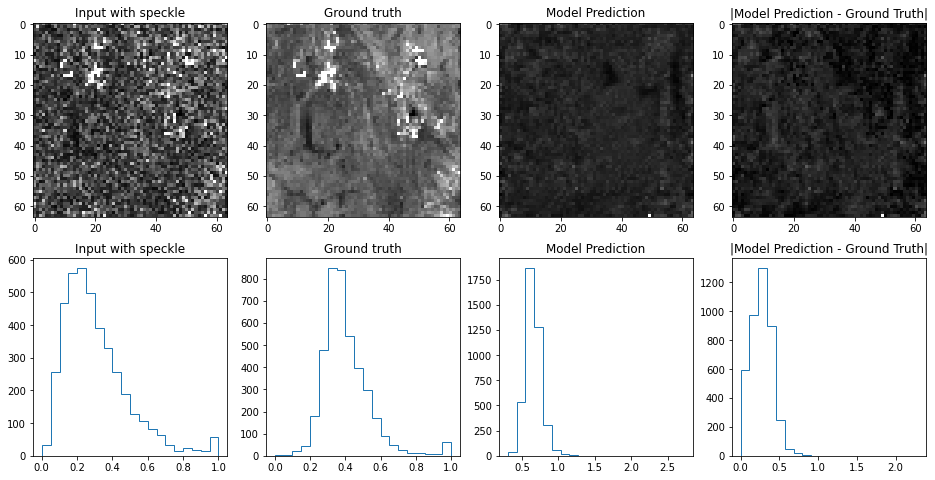

-------------------------------------------------------------------------------------------
Test 14


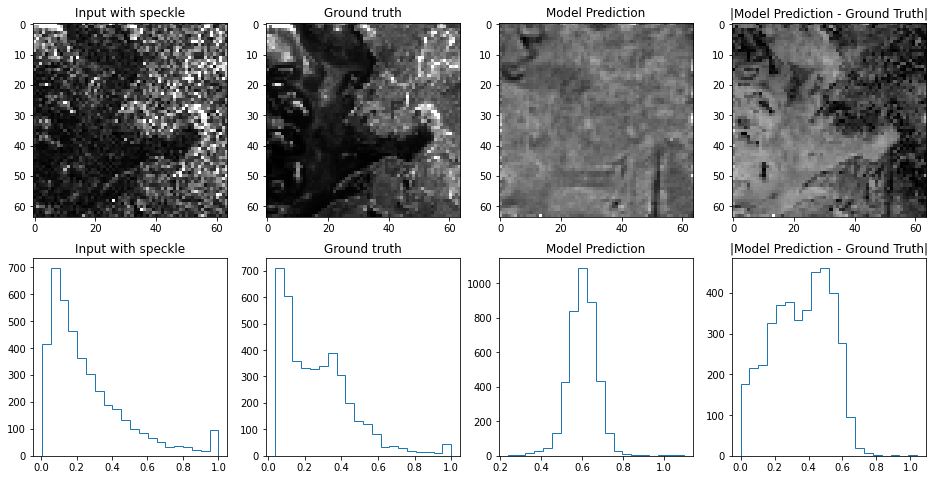

-------------------------------------------------------------------------------------------
Test 15


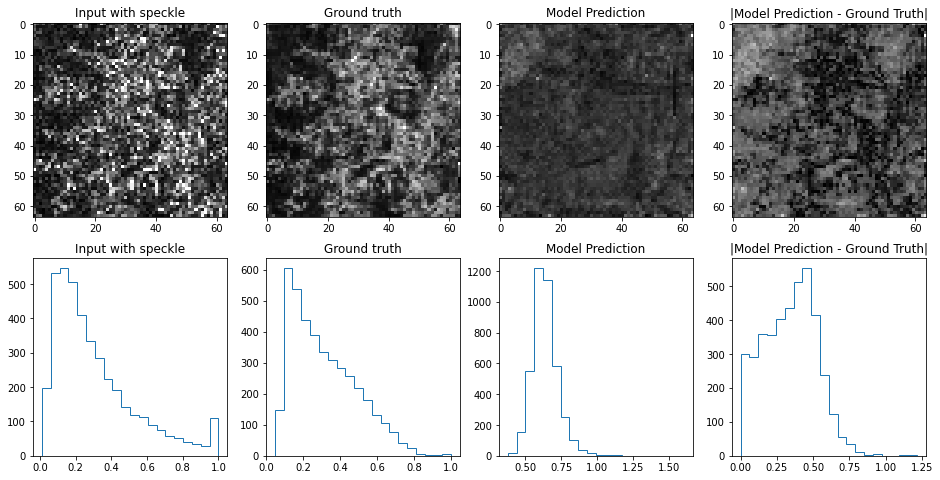

-------------------------------------------------------------------------------------------
Test 16


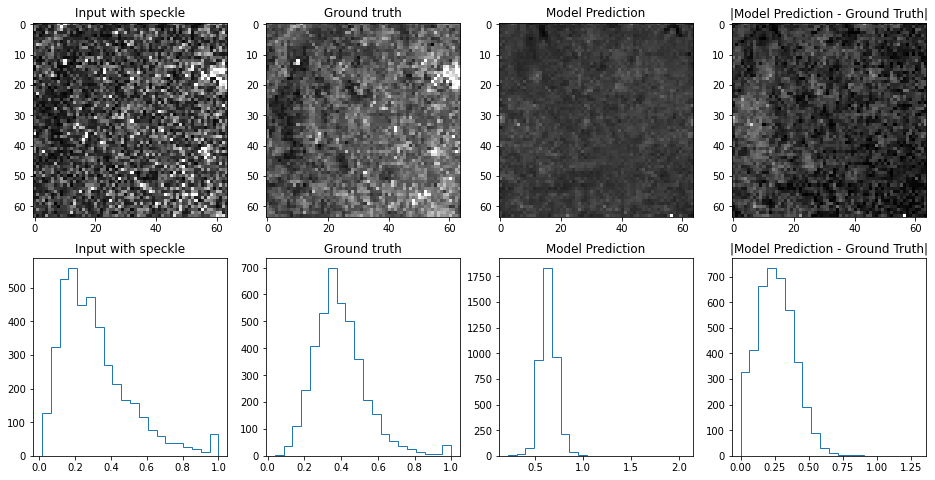

-------------------------------------------------------------------------------------------
Test 17


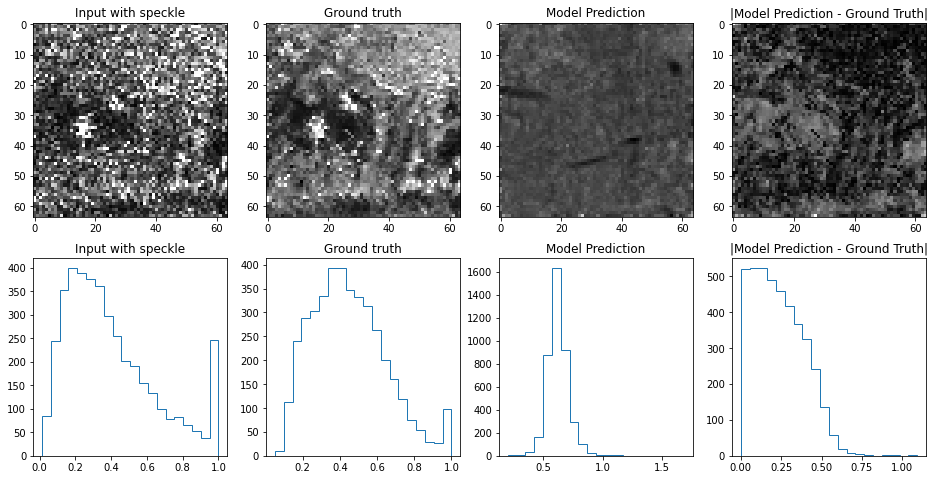

-------------------------------------------------------------------------------------------
Test 18


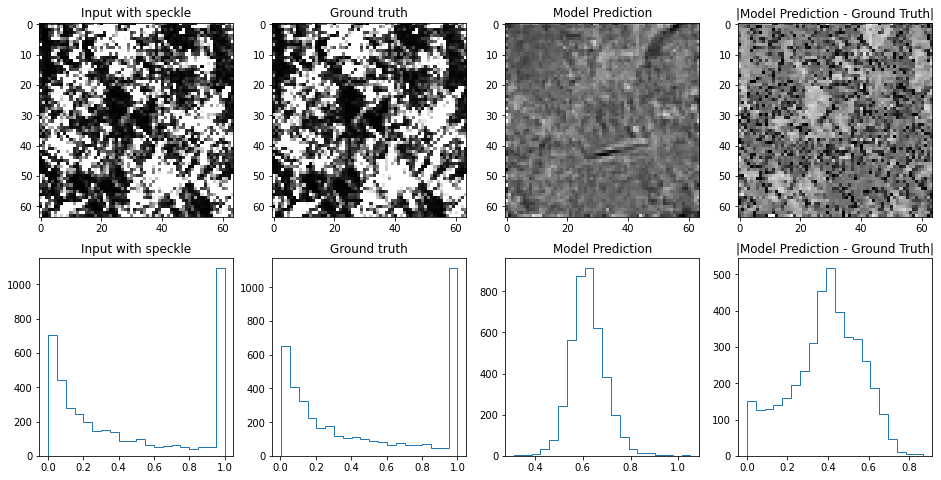

-------------------------------------------------------------------------------------------
Test 19


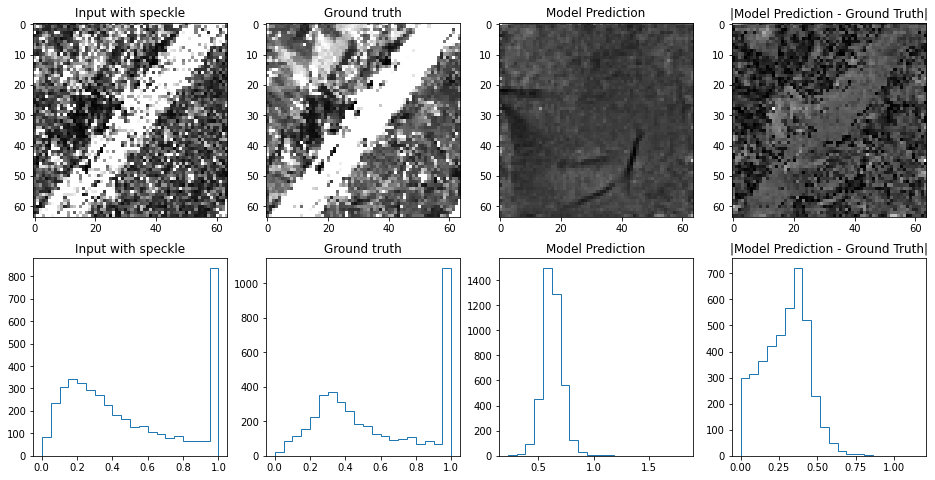

-------------------------------------------------------------------------------------------
Test 20


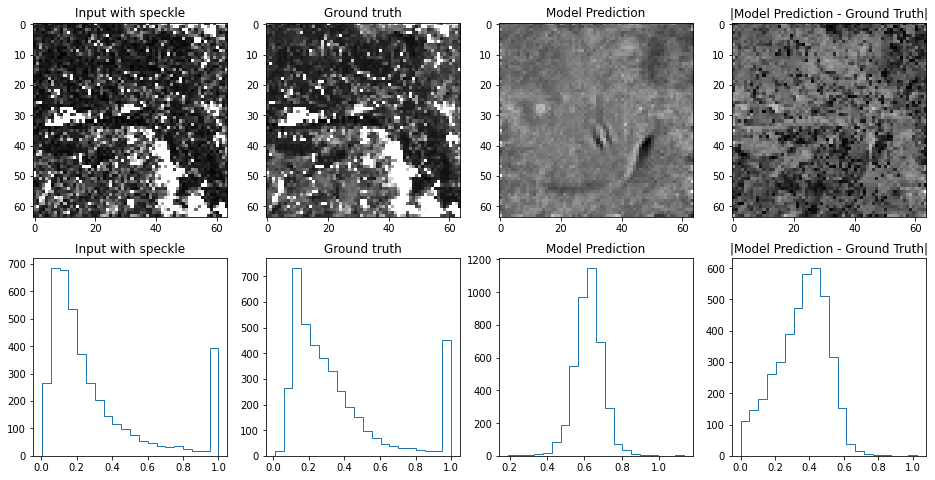

-------------------------------------------------------------------------------------------
Test 21


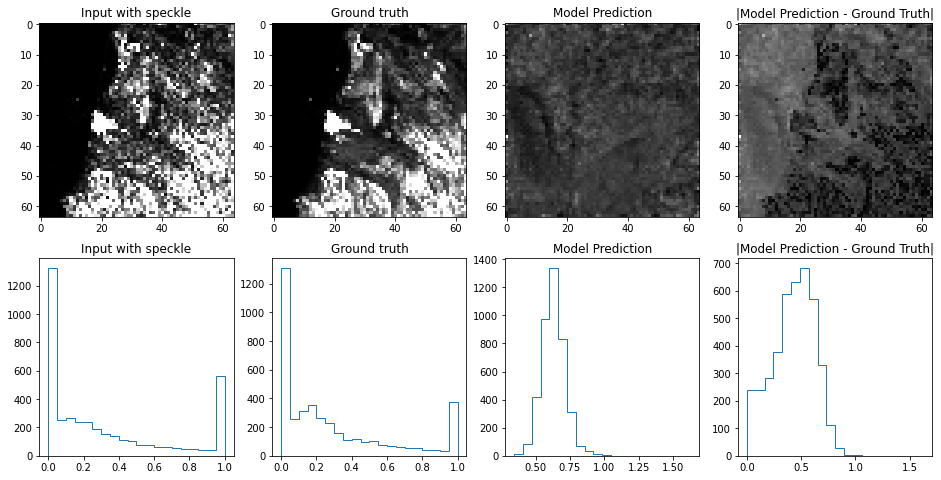

-------------------------------------------------------------------------------------------
Test 22


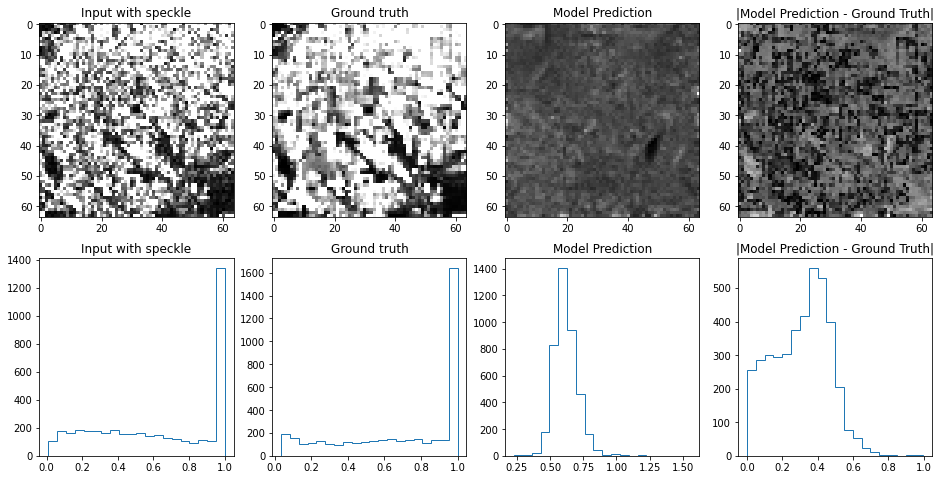

-------------------------------------------------------------------------------------------
Test 23


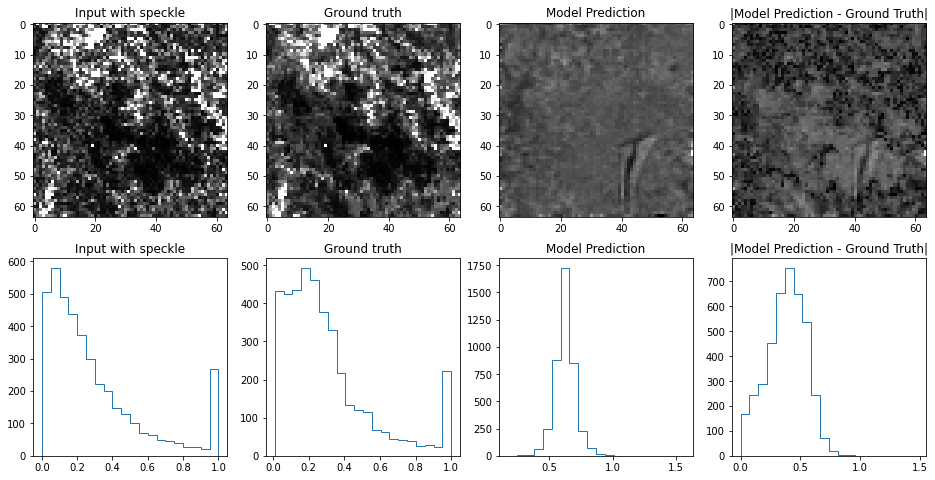

-------------------------------------------------------------------------------------------
Test 24


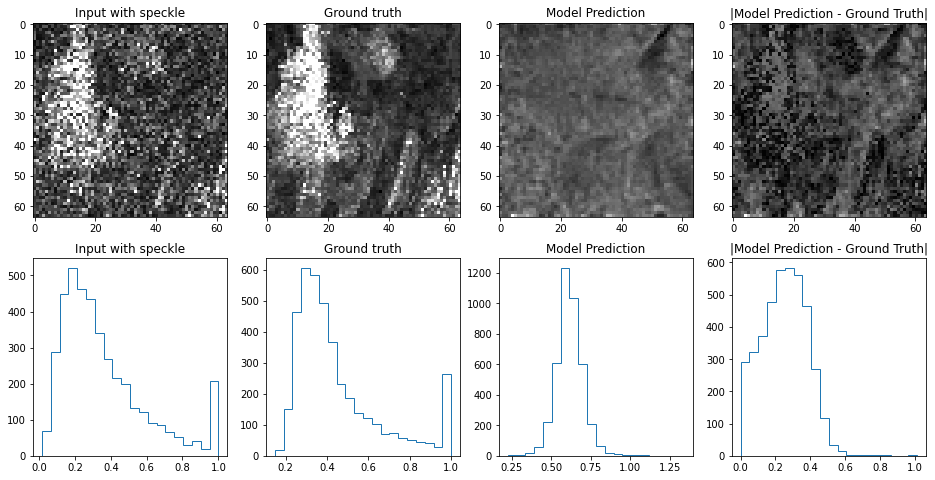

-------------------------------------------------------------------------------------------
Test 25


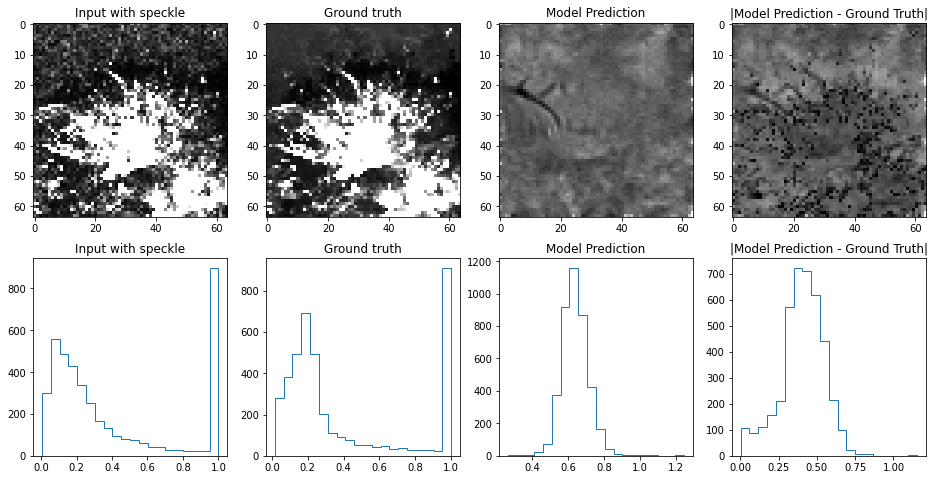

-------------------------------------------------------------------------------------------
Test 26


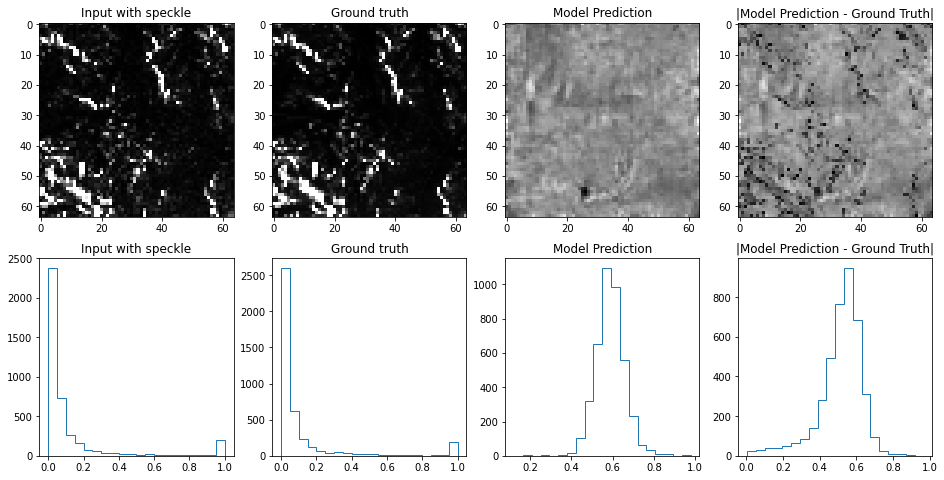

-------------------------------------------------------------------------------------------
Test 27


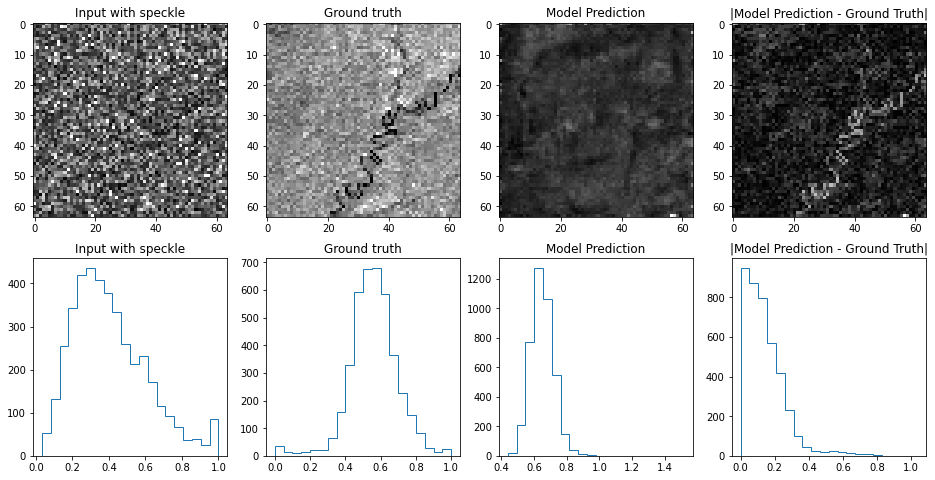

-------------------------------------------------------------------------------------------
Test 28


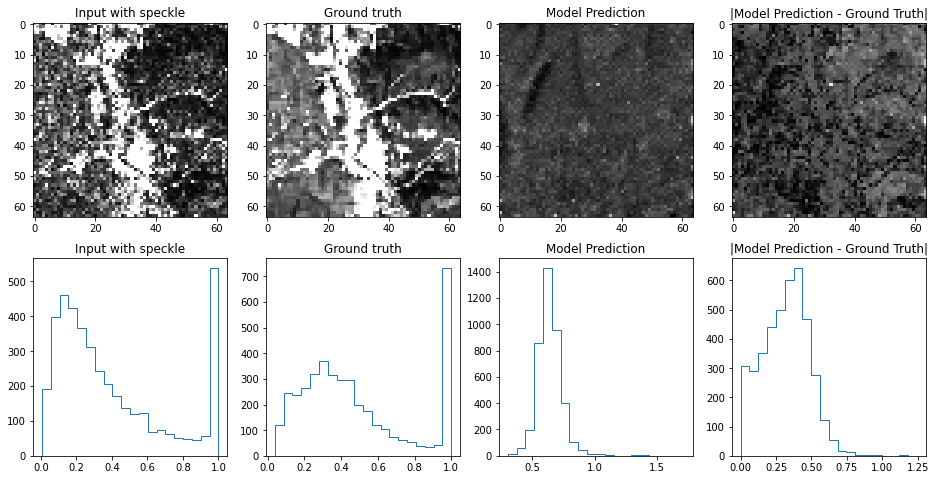

-------------------------------------------------------------------------------------------
Test 29


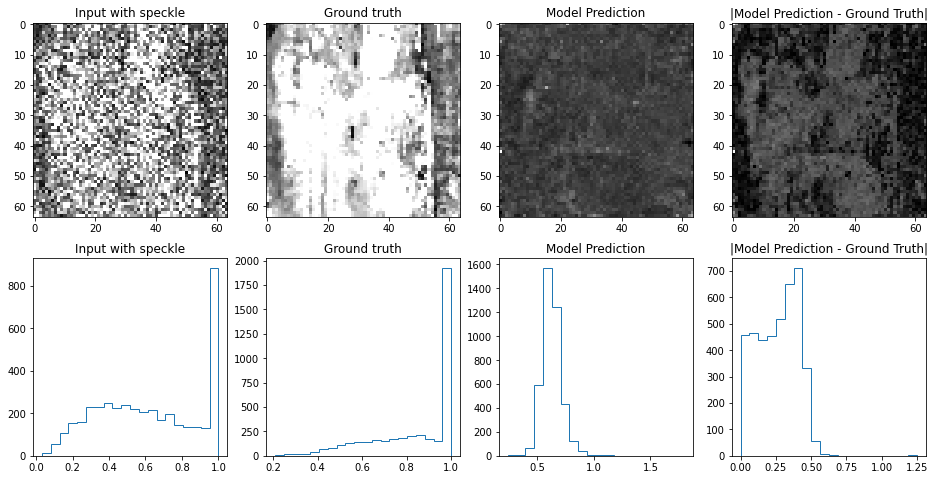

-------------------------------------------------------------------------------------------
Test 30


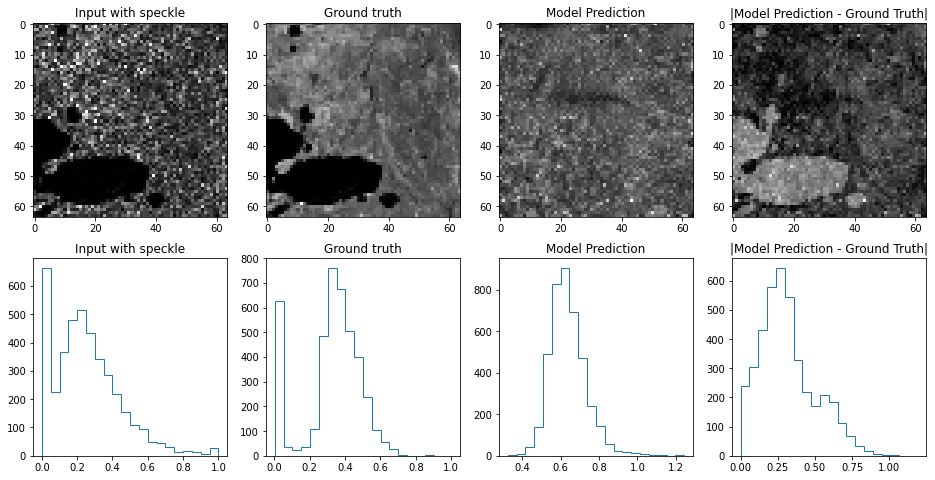

-------------------------------------------------------------------------------------------
Test 31


KeyboardInterrupt: 

In [24]:
plot_model_results(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], out)
compute_metrics(batch_speckle[:,:64,:64,...], batch_clean[:,:64,:64,...], out)